In [1]:
import time
import numpy as np
import random
import torch.nn.functional as F
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
 
from torch.utils.data import DataLoader
 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow( img, one_channel=False,arr= False ):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if arr:
      if one_channel:
          arr.imshow(npimg, cmap="Greys")
      else:
          arr.imshow(np.transpose(npimg, (1, 2, 0)))
    else :
      if one_channel:
          plt.imshow(npimg, cmap="Greys")
      else:
          plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
 #(Fashion) MNIST dataset (images and labels)
train_MNIST_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           #transform=transforms.Compose([
                                           #transforms.Resize((224, 224)),
                                           transform = transforms.ToTensor(),#]),
                                           download=True)
test_MNIST_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=False, 
                                           #transform=transforms.Compose([
                                           #transforms.Resize((224, 224)),
                                           transform = transforms.ToTensor())#]))
train_FMNIST_dataset = torchvision.datasets.FashionMNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)
test_FMNIST_dataset = torchvision.datasets.FashionMNIST(root='../../data', 
                                           train=False, 
                                           transform=transforms.ToTensor())

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw


Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw


Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw




Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw
Processing...
Done!


torch.Size([1, 28, 28])


(None, 6)

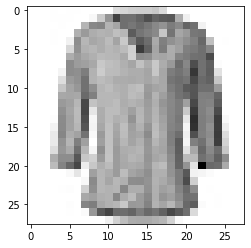

In [11]:
x, y = test_FMNIST_dataset.__getitem__(4)
print(x.shape)
matplotlib_imshow(x, True), y

In [12]:
len(train_FMNIST_dataset), len(test_FMNIST_dataset)

(60000, 10000)

In [13]:
# Hyper-parameters
num_classes = 10
num_epochs = 1000
learning_rate = 0.01
batch_size = 64

gpu = torch.device('cuda')

In [14]:
train_FMNIST_loader = torch.utils.data.DataLoader(dataset=train_FMNIST_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


test_FMNIST_loader = torch.utils.data.DataLoader(dataset=test_FMNIST_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
train_MNIST_loader = torch.utils.data.DataLoader(dataset=train_MNIST_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


test_MNIST_loader = torch.utils.data.DataLoader(dataset=test_MNIST_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
class Conv_net(nn.Module):
    def __init__(self, num_classes):
        super(Conv_net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(5*5*32, 200)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(200, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.size(0), -1)  # reshape과 동일
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

In [ ]:
# size 구하기
model = Conv_net(num_classes)
x, y = train_MNIST_dataset.__getitem__(5)
tmp = model.layer1(x.reshape((1,1,28,28)))
tmp = model.layer2(tmp)
tmp.shape

torch.Size([1, 32, 5, 5])

In [ ]:
model_FMNIST = Conv_net(num_classes)
model_FMNIST.to(gpu)

model_MNIST = Conv_net(num_classes)
model_MNIST.to(gpu)

# Loss and optimizer

optimizer_FMNIST = optim.Adam(model_FMNIST.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()
optimizer_MNIST = optim.Adam(model_MNIST.parameters(), lr=learning_rate)

In [ ]:
def Accuracy(output, target):
    return torch.sum(torch.max(output, dim=1)[1] == target).float() / float(target.shape[0])

def evaluate(model, test_loader):
    output_list, y_list = [], []
    total_loss = 0.
    
    for X, y in test_loader:
        X = X.to(gpu)
        y = y.to(gpu)

        output = model(X)
        output_list.extend(output)
        y_list.extend(y)
        total_loss += criterion(output, y).data.cpu().numpy()
        
    output_list = torch.stack(output_list)
    y_list = torch.stack(y_list)
        
    return total_loss / len(test_loader.dataset), Accuracy(output_list, y_list), output_list.data, y_list.data

In [ ]:
# train_loss_arr = []
# val_loss_arr = []
# test_loss_arr = []

# best_ACC, final_ACC = -999., -999.
# best_pred, best_y = None, None

# early_stop, early_stop_max = 0., 5.

# for epoch in range(num_epochs):
    
#     epoch_loss = 0.
#     for batch_X, batch_y in train_MNIST_loader:
#         # Convert numpy arrays to torch tensors
#         batch_X = batch_X.to(gpu)
#         batch_y = batch_y.to(gpu)
    
#         # Forward Pass
#         model_MNIST.train()
#         outputs = model_MNIST(batch_X)
#         train_loss = criterion(outputs, batch_y)
#         epoch_loss += train_loss.data
    
#         # Backward and optimize
#         optimizer_MNIST.zero_grad()
#         train_loss.backward()
#         optimizer_MNIST.step()
        
#     train_loss_arr.append(epoch_loss / len(train_MNIST_loader.dataset))
 
#     if epoch % 1 == 0:
#         model_MNIST.eval()
        
#         train_loss, ACC_train, _, _ = evaluate(model_MNIST, train_MNIST_loader)
#         test_loss, ACC_test, test_pred, test_y = evaluate(model_MNIST, test_MNIST_loader)
        
#         test_loss_arr.append(test_loss)
        
#         print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Train ACC: {:.4f}, Test ACC: {:.4f} *'.format(epoch, num_epochs, train_loss, test_loss, ACC_train, ACC_test))


In [ ]:
#x, y = test_FMNIST_dataset.__getitem__(210)
#print(torch.max(model_FMNIST(x.reshape((1,1,28,28)).to(gpu)), dim=1)[1])
#matplotlib_imshow(x, True), y

In [ ]:
#torch.save(model_FMNIST,'./model_FMNIST.pt') #모델 저장 #model = torch.load('./model.pt') #모델 가져오기

In [ ]:
#torch.save(model_MNIST,'./model_MNIST.pt') #모델 저장 #model = torch.load('./model.pt') #모델 가져오기

In [ ]:
model_FMNIST = torch.load('./model_FMNIST.pt',map_location=torch.device('cpu')) #모델 가져오기
model_MNIST = torch.load('./model_MNIST.pt',map_location=torch.device('cpu')) #모델 가져오기

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, latent_size):
        super(AutoEncoder, self).__init__()
        self.VAE_encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding= 1, stride=(2,2)),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding= 1),
            nn.ReLU()
        )
        self.VAE_decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2,padding= 1,stride=(2,2)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3)
        )
        self.VAE_mu = nn.Linear(64 * 14 * 14, latent_size)
        self.VAE_logvar = nn.Linear(64 * 14 * 14, latent_size)
        self.VAE_upsample = nn.Linear(latent_size, 64 * 14 * 14)
   
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            #nn.ReLU(),
            #nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size,hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim)
        )
        self.mu = nn.Linear(hidden_dim1, latent_size)
        self.logvar = nn.Linear(hidden_dim1, latent_size)
    
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #print(eps.mul(std).add_(mu)-mu)
        return eps.mul(std).add_(mu)
    # def forward(self, x):
    #     x = self.VAE_encoder(x).relu().view(x.size(0), -1)
    #     #print(x.shape)
    #     mu = self.VAE_mu(x)
    #     logvar = self.VAE_logvar(x)
    #     sample = self.reparameterize(mu, logvar)
    #     #print(sample.shape)
    #     result = self.VAE_decoder(self.VAE_upsample(sample).relu().view(-1, 64, 14, 14))
    #     return F.sigmoid(result), mu, logvar
    # def get_codes(self, x):
    #     x = self.VAE_encoder(x).relu().view(x.size(0), -1)
        
    #     mu = self.VAE_mu(x)
    #     logvar = self.VAE_logvar(x)
    #     sample = self.VAE_reparameterize(mu, logvar)
    #     return sample
    # def get_decode(self, x):
    #     sample = x
        
    #     result = self.VAE_decoder(self.VAE_upsample(sample).relu().view(-1, 64, 14, 14))
        # return F.sigmoid(result)
    #     #linear용
    def forward(self, x):
        x = self.encoder(x.view(x.size(0),-1))
        
        mu = self.mu(x)
        logvar = self.logvar(x)
        sample = self.reparameterize(mu, logvar)
        #result = self.decoder(x.reshape(x.size()))
        result = torch.sigmoid(self.decoder(sample))
        return result.view(-1,1,28,28), mu, logvar
    
    def get_codes(self, x):
        out = x.view(x.size(0), -1)
        out = self.encoder(out)
        mu = self.mu(out)
        logvar = self.logvar(out)
        out = self.reparameterize(mu, logvar)
        return out
    def get_decode(self,x):
        return torch.sigmoid(self.decoder(x)).view(-1,1,28,28)

In [ ]:
# class VAE(nn.Module):
#     def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
#         super(VAE, self).__init__()
        
#         # encoder part
#         self.fc1 = nn.Linear(x_dim, h_dim1)
#         self.fc2 = nn.Linear(h_dim1, h_dim2)
#         self.fc31 = nn.Linear(h_dim2, z_dim)
#         self.fc32 = nn.Linear(h_dim2, z_dim)
#         # decoder part
#         self.fc4 = nn.Linear(z_dim, h_dim2)
#         self.fc5 = nn.Linear(h_dim2, h_dim1)
#         self.fc6 = nn.Linear(h_dim1, x_dim)
        
#     def encoder(self, x):
#         h = F.relu(self.fc1(x))
#         h = F.relu(self.fc2(h))
#         return self.fc31(h), self.fc32(h) # mu, log_var
    
#     def sampling(self, mu, log_var):
#         std = torch.exp(0.5*log_var)
#         eps = torch.randn_like(std)
#         return eps.mul(std).add_(mu) # return z sample
        
#     def decoder(self, z):
#         h = F.relu(self.fc4(z))
#         h = F.relu(self.fc5(h))
#         return F.sigmoid(self.fc6(h)) 
    
#     def forward(self, x):
#         mu, log_var = self.encoder(x.view(-1, 784))
#         z = self.sampling(mu, log_var)
#         return self.decoder(z), mu, log_var


In [ ]:
# AE = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=32)
# AE = AE.to(gpu)
# learning_rate = 0.01
# AE_optimizer = optim.Adam(AE.parameters(), lr=learning_rate)

In [ ]:
def loss_VAE(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x.view(-1,784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
# MSE_  = nn.MSELoss()
# def loss_VAE(decoded, original, mu, log_var):
#     MSE = MSE_(decoded,original)
#     #print(MSE.shape)
    
#     #print(KLD.shape)
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     #print(MSE,KLD)
#     return MSE + KLD#/(batch_size*784)

In [15]:
latent_size = 100
AE = AutoEncoder(28 * 28, 64, latent_size)
AE = AE.to(gpu)
learning_rate = 0.01
AE_optimizer = optim.Adam(AE.parameters(), lr=learning_rate)

In [ ]:
AE

AutoEncoder(
  (VAE_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (VAE_decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  )
  (VAE_mu): Linear(in_features=12544, out_features=100, bias=True)
  (VAE_logvar): Linear(in_features=12544, out_features=100, bias=True)
  (VAE_upsample): Linear(in_features=100, out_features=12544, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=64,

In [ ]:
model_MNIST.cpu()

Conv_net(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=200, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
def train(model, optimizer,train_loader,test_loader):
    train_loss_arr = []
    test_loss_arr = []

    best_test_loss = 9999999
    early_stop, early_stop_max = 0., 3.
    total_len = len(train_loader.dataset)
    for epoch in range(num_epochs):
        model.to(gpu)

        epoch_loss = 0.
        ACC_train = 0
        for batch_X, _ in train_loader:

            # Convert numpy arrays to torch tensors
            batch_X = batch_X.to(gpu)

            optimizer.zero_grad()

            # Forward Pass
            model.train()
            outputs, mu_, logvar_ = model(batch_X)
            #print(outputs.shape,mu_.shape,logvar_.shape)
            train_loss = loss_VAE(outputs, batch_X, mu_, logvar_)
            epoch_loss += train_loss.data

            # Backward and optimize
            train_loss.backward()
            optimizer.step()

        if epoch % 1 == 0:
            model.eval()
            test_loss = 0
            for batch_X, _ in test_loader:

              # Convert numpy arrays to torch tensors
              batch_X = batch_X.to(gpu)


              # Forward Pass
              outputs, mu_, logvar_ = model(batch_X)
              #print(outputs.shape,mu_.shape,logvar_.shape)
              test_loss += loss_VAE(outputs, batch_X, mu_, logvar_).data
              
            #train_loss, ACC_train, _, _ = evaluate(model, train_loader, loss_VAE)
            #test_loss, ACC_test, test_pred, test_y = evaluate(model, test_loader,loss_VAE)
            test_loss_arr.append(test_loss)
            #test_loss /=len(test_loader.dataset)
        
           


            if best_test_loss > test_loss:
                best_test_loss = test_loss
                early_stop = 0
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f} *'.format(epoch, num_epochs, epoch_loss/len(train_loader.dataset), test_loss/len(test_loader.dataset)))

            else:
                early_stop += 1
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f} '.format(epoch, num_epochs, epoch_loss/len(train_loader.dataset), test_loss/len(test_loader.dataset)))
                
            

        if early_stop >= early_stop_max:
            break

In [ ]:
train(AE,  AE_optimizer,train_FMNIST_loader,test_FMNIST_loader)

Epoch [0/1000], Train Loss: 303.9535, Test Loss: 287.3941 *
Epoch [1/1000], Train Loss: 283.2972, Test Loss: 282.6726 *
Epoch [2/1000], Train Loss: 281.2826, Test Loss: 281.5238 *
Epoch [3/1000], Train Loss: 280.1564, Test Loss: 280.9161 *
Epoch [4/1000], Train Loss: 279.8092, Test Loss: 281.5976 
Epoch [5/1000], Train Loss: 279.3129, Test Loss: 279.2607 *
Epoch [6/1000], Train Loss: 278.8329, Test Loss: 279.6734 
Epoch [7/1000], Train Loss: 278.6383, Test Loss: 280.8533 
Epoch [8/1000], Train Loss: 278.5119, Test Loss: 279.2782 


(None, 7)

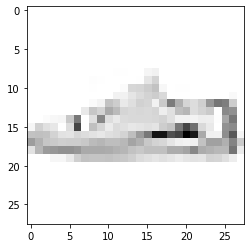

In [ ]:
x, y = test_FMNIST_dataset.__getitem__(925)
matplotlib_imshow(x, True), y

torch.Size([1, 28, 28])
7


(None, 7)

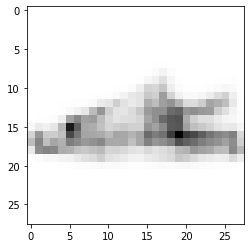

In [ ]:
a = AE_FMNIST(x.reshape((1,1,28,28)))[0].cpu().data.reshape(1,28,28)
print(a.shape)
b =  AE_FMNIST.get_codes(x.reshape((1,1,28,28))).data.reshape(32)
c = AE_FMNIST.get_decode(b)
print(torch.max(model_FMNIST(c.reshape(1,1,28,28)), dim=1)[1].numpy()[0])
matplotlib_imshow(a, True), torch.max(model_FMNIST(a.reshape(1,1,28,28)), dim=1)[1].numpy()[0]

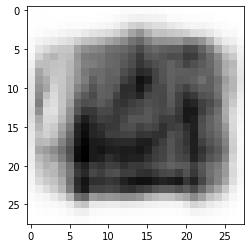

In [ ]:
x_9, y = test_FMNIST_dataset.__getitem__(4)
x_4, y = test_FMNIST_dataset.__getitem__(43)
matplotlib_imshow(AE.get_decode(AE.get_codes(x_4.view(x_4.size(0), -1))*0.5+AE.get_codes(x_9.view(x_9.size(0), -1))*0.5).cpu().data.reshape(1,28,28), True)

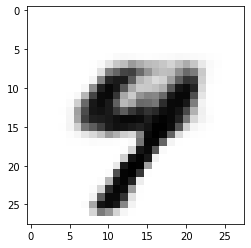

In [ ]:
x_9, y = test_MNIST_dataset.__getitem__(9)
x_4, y = test_MNIST_dataset.__getitem__(4)
matplotlib_imshow(AE_MNIST.get_decode(AE_MNIST.get_codes(x_4.view(x_4.size(0), -1))*0+AE_MNIST.get_codes(x_9.view(x_9.size(0), -1))*1).cpu().data.reshape(1,28,28), True)

In [ ]:
#torch.save(AE,'./VAE_FMNIST_32.pt') #모델 저장 #model = torch.load('./model.pt') #모델 가져오기

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 32 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [18]:
AE_FMNIST = torch.load('./VAE_FMNIST_32.pt',map_location=torch.device('cpu')) #모델 가져오기
AE_MNIST = torch.load('./VAE_MNIST_10.pt',map_location=torch.device('cpu')) #모델 가져오기
LSGAN_FMNIST = torch.load('model_LSGAN_g_3.pt',map_location=torch.device('cpu'))
model_MNIST = torch.load('./model_MNIST.pt',map_location=torch.device('cpu'))
model_FMNIST = torch.load('./model_FMNIST.pt',map_location=torch.device('cpu'))
AE_FMNIST.eval()
AE_MNIST.eval()
LSGAN_FMNIST.eval()
model_MNIST.eval()
model_FMNIST.eval()

Conv_net(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=200, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

torch.Size([32, 1, 28, 28])
tensor([3])


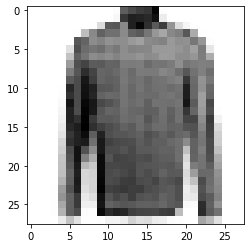

torch.Size([32, 1, 28, 28])
tensor([3])


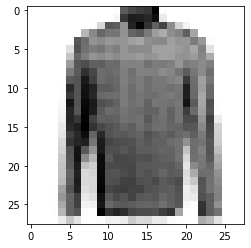

torch.Size([32, 1, 28, 28])
tensor([3])


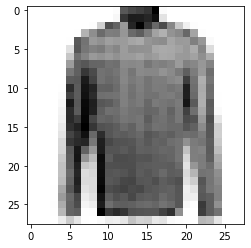

torch.Size([32, 1, 28, 28])
tensor([3])


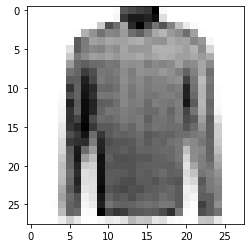

torch.Size([32, 1, 28, 28])
tensor([3])


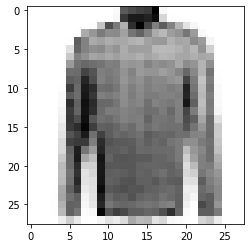

torch.Size([32, 1, 28, 28])
tensor([3])


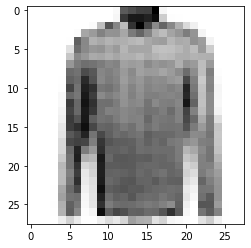

torch.Size([32, 1, 28, 28])
tensor([3])


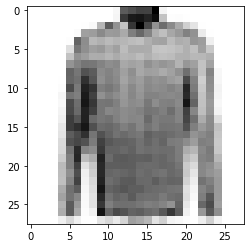

torch.Size([32, 1, 28, 28])
tensor([8])


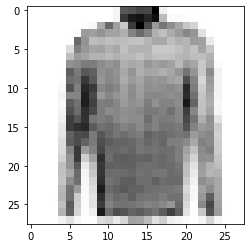

torch.Size([32, 1, 28, 28])
tensor([8])


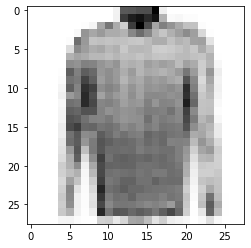

torch.Size([32, 1, 28, 28])
tensor([8])


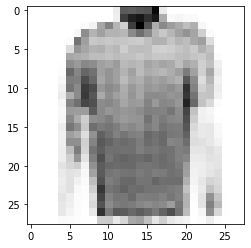

torch.Size([32, 1, 28, 28])
tensor([8])


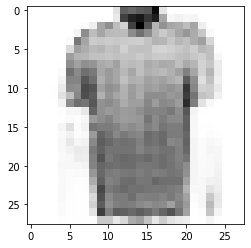

torch.Size([32, 1, 28, 28])
tensor([8])


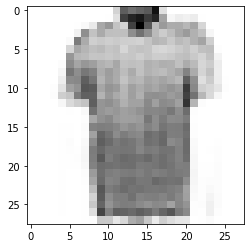

torch.Size([32, 1, 28, 28])
tensor([8])


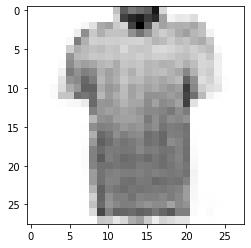

torch.Size([32, 1, 28, 28])
tensor([8])


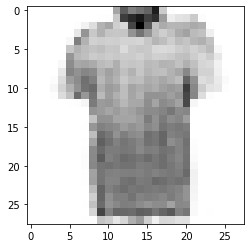

torch.Size([32, 1, 28, 28])
tensor([8])


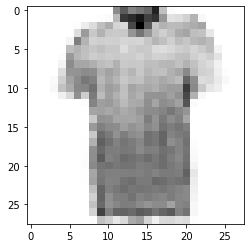

torch.Size([32, 1, 28, 28])
tensor([8])


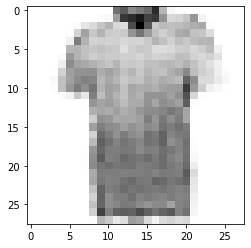

torch.Size([32, 1, 28, 28])
tensor([8])


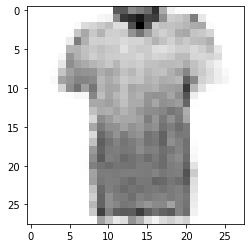

torch.Size([32, 1, 28, 28])
tensor([8])


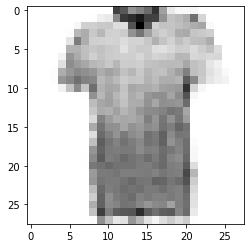

torch.Size([32, 1, 28, 28])
tensor([8])


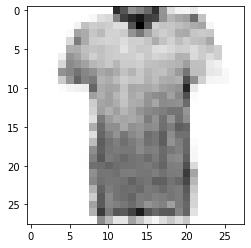

torch.Size([32, 1, 28, 28])
tensor([8])


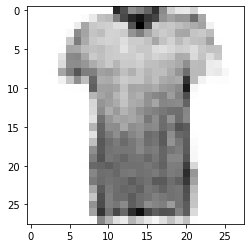

torch.Size([32, 1, 28, 28])
tensor([8])


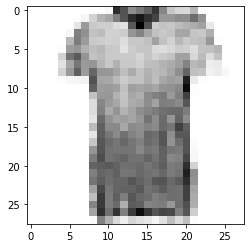

torch.Size([32, 1, 28, 28])
tensor([8])


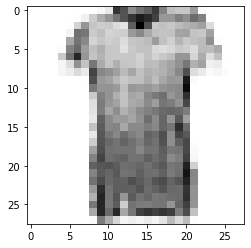

torch.Size([32, 1, 28, 28])
tensor([8])


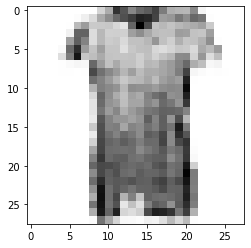

torch.Size([32, 1, 28, 28])
tensor([8])


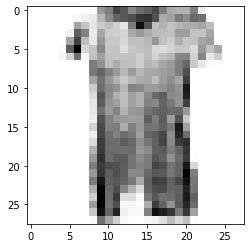

torch.Size([32, 1, 28, 28])
tensor([8])


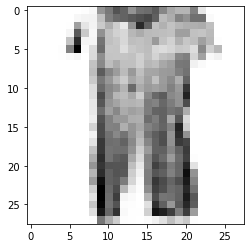

torch.Size([32, 1, 28, 28])
tensor([8])


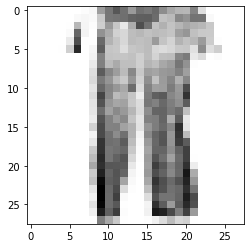

torch.Size([32, 1, 28, 28])
tensor([8])


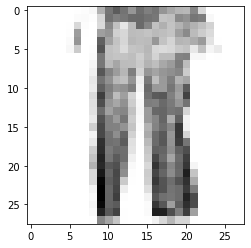

torch.Size([32, 1, 28, 28])
tensor([8])


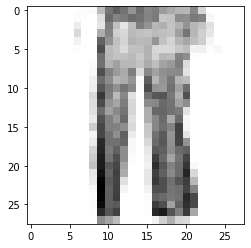

torch.Size([32, 1, 28, 28])
tensor([8])


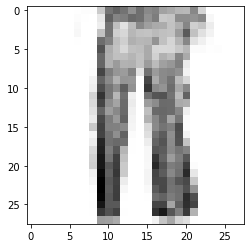

torch.Size([32, 1, 28, 28])
tensor([8])


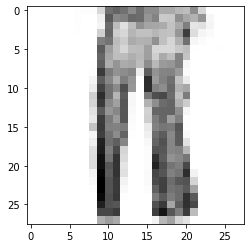

torch.Size([32, 1, 28, 28])
tensor([8])


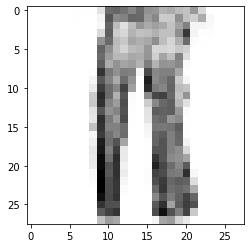

torch.Size([32, 1, 28, 28])
tensor([8])


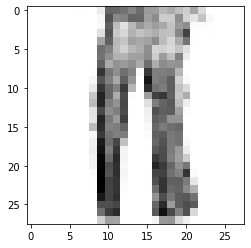

torch.Size([32, 1, 28, 28])
tensor([8])


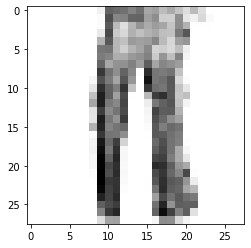

torch.Size([32, 1, 28, 28])
tensor([8])


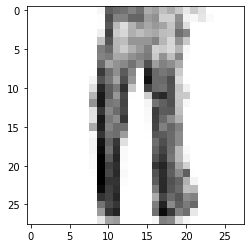

torch.Size([32, 1, 28, 28])
tensor([8])


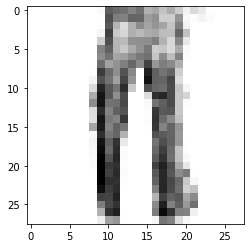

torch.Size([32, 1, 28, 28])
tensor([8])


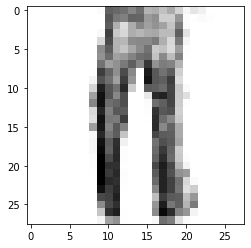

torch.Size([32, 1, 28, 28])
tensor([8])


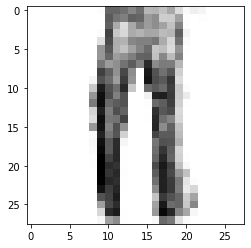

torch.Size([32, 1, 28, 28])
tensor([8])


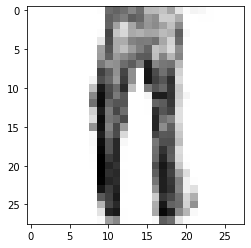

torch.Size([32, 1, 28, 28])
tensor([8])


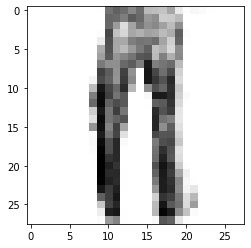

torch.Size([32, 1, 28, 28])
tensor([8])


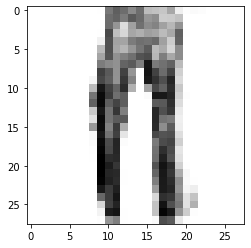

torch.Size([32, 1, 28, 28])
tensor([8])


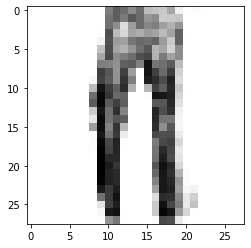

torch.Size([32, 1, 28, 28])
tensor([8])


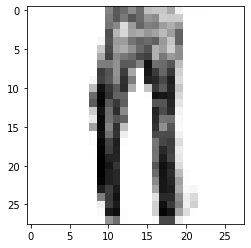

torch.Size([32, 1, 28, 28])
tensor([8])


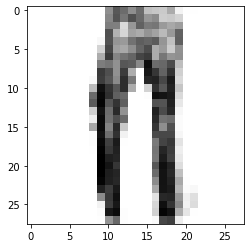

torch.Size([32, 1, 28, 28])
tensor([8])


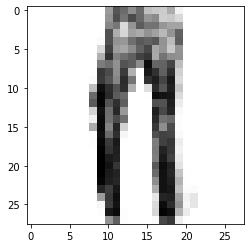

torch.Size([32, 1, 28, 28])
tensor([8])


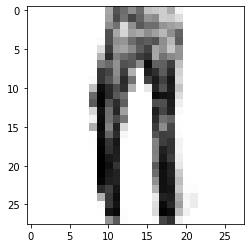

torch.Size([32, 1, 28, 28])
tensor([8])


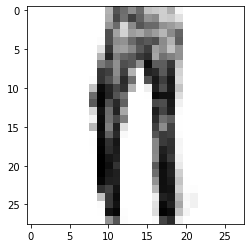

torch.Size([32, 1, 28, 28])
tensor([8])


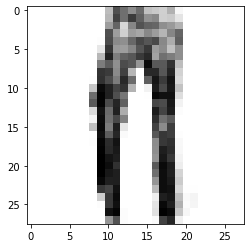

torch.Size([32, 1, 28, 28])
tensor([8])


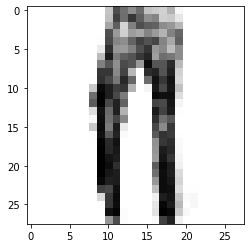

torch.Size([32, 1, 28, 28])
tensor([8])


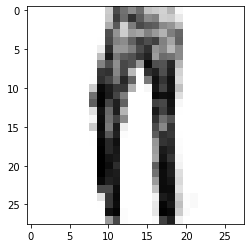

torch.Size([32, 1, 28, 28])
tensor([8])


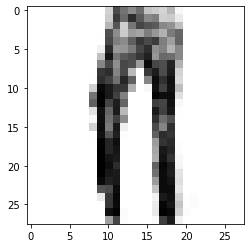

torch.Size([32, 1, 28, 28])
tensor([8])


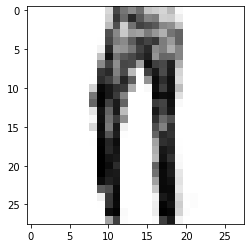

torch.Size([32, 1, 28, 28])
tensor([8])


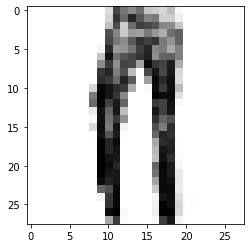

torch.Size([32, 1, 28, 28])
tensor([8])


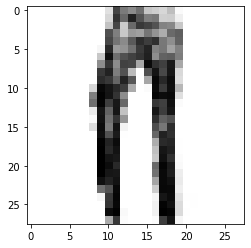

torch.Size([32, 1, 28, 28])
tensor([8])


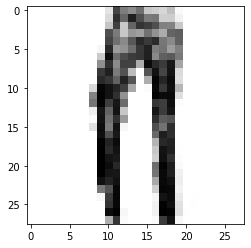

torch.Size([32, 1, 28, 28])
tensor([8])


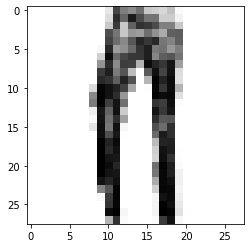

torch.Size([32, 1, 28, 28])
tensor([8])


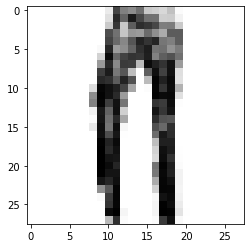

torch.Size([32, 1, 28, 28])
tensor([8])


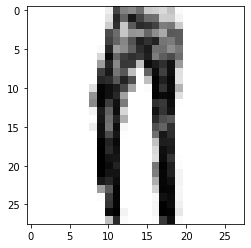

torch.Size([32, 1, 28, 28])
tensor([8])


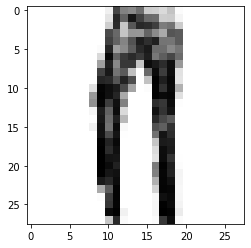

torch.Size([32, 1, 28, 28])
tensor([8])


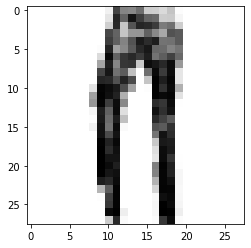

torch.Size([32, 1, 28, 28])
tensor([8])


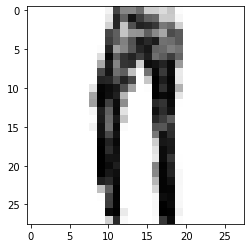

torch.Size([32, 1, 28, 28])
tensor([8])


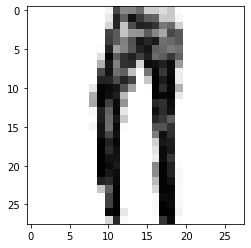

torch.Size([32, 1, 28, 28])
tensor([8])


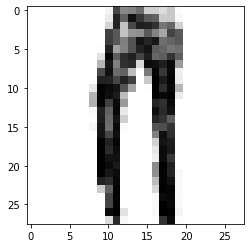

torch.Size([32, 1, 28, 28])
tensor([8])


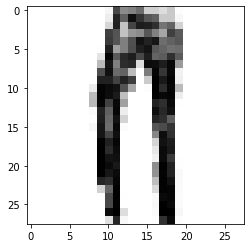

torch.Size([32, 1, 28, 28])
tensor([8])


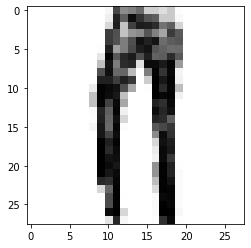

torch.Size([32, 1, 28, 28])
tensor([8])


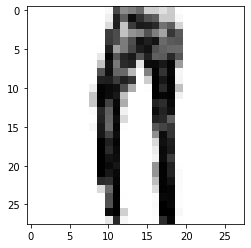

torch.Size([32, 1, 28, 28])
tensor([8])


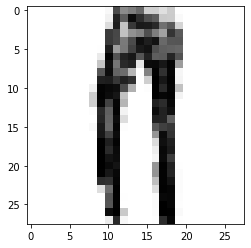

torch.Size([32, 1, 28, 28])
tensor([8])


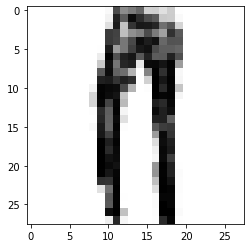

torch.Size([32, 1, 28, 28])
tensor([8])


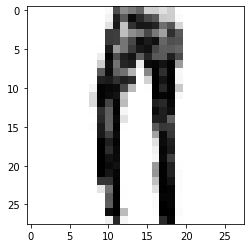

torch.Size([32, 1, 28, 28])
tensor([8])


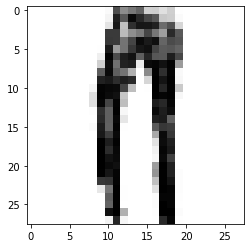

torch.Size([32, 1, 28, 28])
tensor([8])


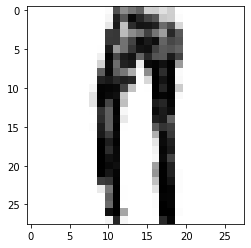

torch.Size([32, 1, 28, 28])
tensor([8])


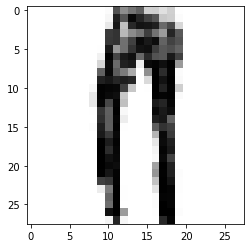

torch.Size([32, 1, 28, 28])
tensor([8])


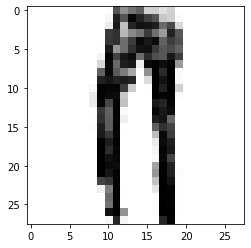

torch.Size([32, 1, 28, 28])
tensor([8])


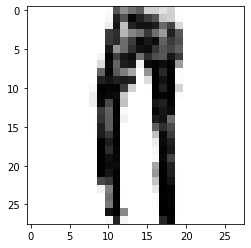

torch.Size([32, 1, 28, 28])
tensor([8])


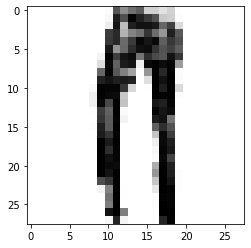

torch.Size([32, 1, 28, 28])
tensor([8])


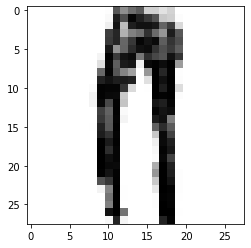

torch.Size([32, 1, 28, 28])
tensor([8])


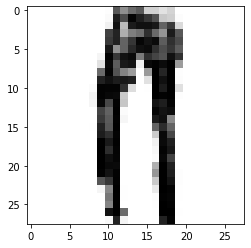

torch.Size([32, 1, 28, 28])
tensor([8])


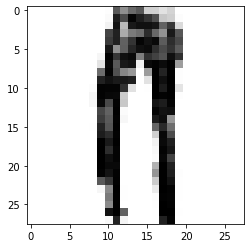

torch.Size([32, 1, 28, 28])
tensor([8])


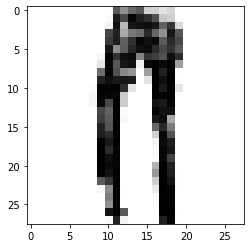

torch.Size([32, 1, 28, 28])
tensor([8])


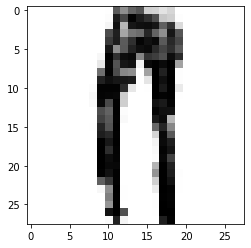

torch.Size([32, 1, 28, 28])
tensor([8])


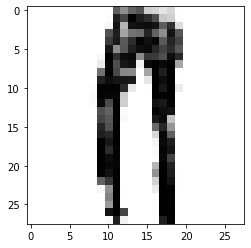

torch.Size([32, 1, 28, 28])
tensor([8])


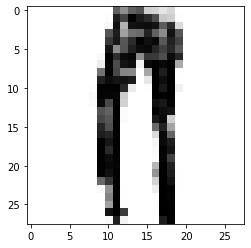

torch.Size([32, 1, 28, 28])
tensor([8])


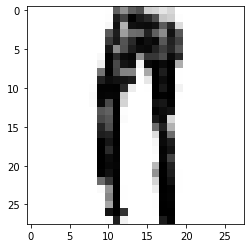

torch.Size([32, 1, 28, 28])
tensor([8])


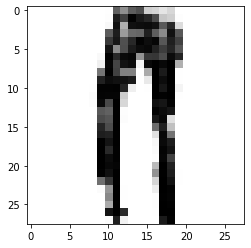

torch.Size([32, 1, 28, 28])
tensor([8])


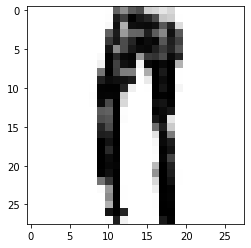

torch.Size([32, 1, 28, 28])
tensor([8])


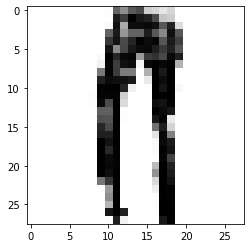

torch.Size([32, 1, 28, 28])
tensor([8])


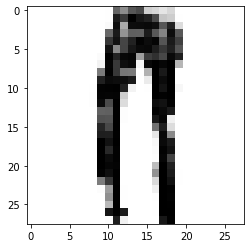

torch.Size([32, 1, 28, 28])
tensor([8])


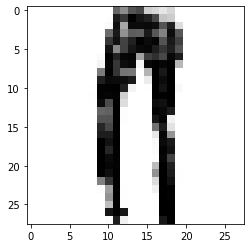

torch.Size([32, 1, 28, 28])
tensor([8])


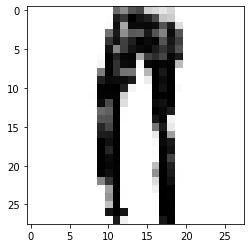

torch.Size([32, 1, 28, 28])
tensor([8])


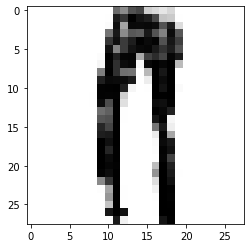

torch.Size([32, 1, 28, 28])
tensor([8])


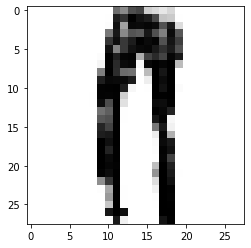

torch.Size([32, 1, 28, 28])
tensor([8])


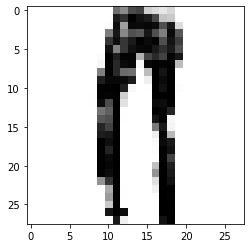

torch.Size([32, 1, 28, 28])
tensor([8])


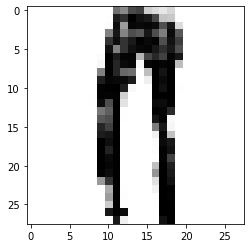

torch.Size([32, 1, 28, 28])
tensor([8])


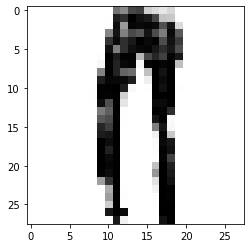

torch.Size([32, 1, 28, 28])
tensor([8])


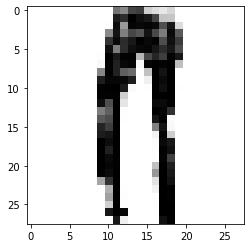

torch.Size([32, 1, 28, 28])
tensor([8])


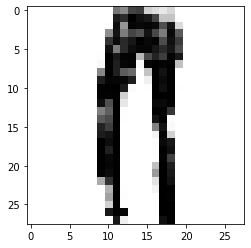

torch.Size([32, 1, 28, 28])
tensor([8])


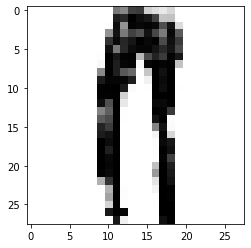

torch.Size([32, 1, 28, 28])
tensor([8])


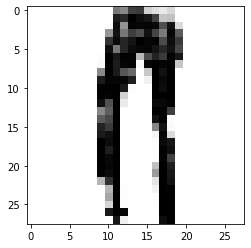

torch.Size([32, 1, 28, 28])
tensor([8])


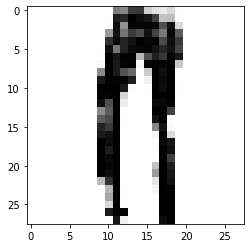

torch.Size([32, 1, 28, 28])
tensor([8])


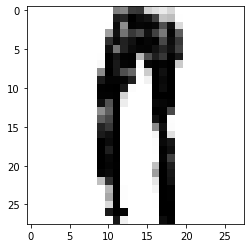

torch.Size([32, 1, 28, 28])
tensor([8])


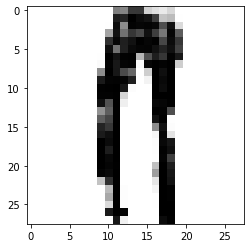

In [68]:
#z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (32, 100))))
#tmp = z
z = tmp
for i in range(100):

  z = tmp
  z = z-i *0.05
  gen_img =LSGAN_FMNIST(z)
  print(gen_img.shape)
  print(torch.max(model_FMNIST(gen_img[1].reshape(1,1,28,28)), dim=1)[1])
  matplotlib_imshow(gen_img[3].cpu().data, True)
  plt.pause(0.05)

In [ ]:
def fitness(x_encoded, x_origin, NN_model, model):
  if model == LSGAN_FMNIST:
    x_ori_de =model(x_origin.reshape(1,100))
    x_decoded = model(x_encoded.reshape(1,100))
  else :
  #torch.max(model(x.reshape((1,1,28,28))), dim=1)[1]
    x_decoded = model.get_decode(x_encoded)#.reshape((1,5,20,20)))
    x_ori_de = model.get_decode(x_origin)#.reshape((1,5,20,20)))
  a = (torch.max(NN_model(x_decoded), dim=1)[1]).numpy()[0]
  b = (torch.max(NN_model(x_ori_de), dim=1)[1]).numpy()[0]
  if a == b:
    
  #if torch.max(model(x_decoded.reshape((1,1,28,28))), dim=1)[1] == torch.max(model(x_ori_de.reshape((1,1,28,28))), dim=1)[1]:
    fitness = 9999999
    return fitness
  else :
    fitness = torch.norm(x_encoded-x_origin)
    #print(a,b)
    return fitness
def random_solution(x,latent,model):
  if model == LSGAN_FMNIST :
    x_encode = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (100))))

    s = torch.Tensor(np.random.normal(size=100)*0.003)
    encoded = s+x_encode
  else :
    x_encode = model.get_codes(x.reshape((1,1,28,28))).data.reshape(latent)#.reshape(2000)
    s = torch.Tensor(np.random.normal(size=latent)*0.3)
    encoded = s+x_encode
  return encoded
def selection(pop, k):
  tournament_pool = random.sample(pop, k)
  result = sorted(tournament_pool, key=lambda x: x[0], reverse=False)
  return result[0]
def mutate(solution, rate,x, latent,NN_model,model):
  if random.random() < rate:
    if model == LSGAN_FMNIST:
      solution_tmp = solution[1]+ torch.Tensor(np.random.normal(size=latent)*0.003)
    else :
      solution_tmp = solution[1]+ torch.Tensor(np.random.normal(size=latent)*0.3)
  else :
    solution_tmp = solution[1]
  return (fitness(solution_tmp,x, NN_model,model),solution_tmp)


def crossover(p1, p2,x,NN_model,model):
  s = [i for i in range(len(p1[1]))]
  cut_index = np.random.choice(s, 2)
  cut_index = sorted(cut_index)
  o_1 = [0] *len(p1[1])
  o_2 = [0] * len(p2[1])
  #print(cut_index[0], p1[1])
  o1 = p1[1][cut_index[0]:cut_index[1]+1]
  o2 = p2[1][cut_index[0]:cut_index[1]+1]
  tmp_p1 = p1[1]
  tmp_p2 = p2[1]
  #print(p1[1].shape)
  for i in range(cut_index[0],cut_index[1]+1):
    for j in range(len(p2[1])):
      if p2[1][j]==p1[1][i]:
        tmp_p2[i],tmp_p2[j] = tmp_p2[j],tmp_p2[i]
  for i in range(cut_index[0],cut_index[1]+1):
    for j in range(len(p1[1])):
      if p1[1][j]==p2[1][i]:
        tmp_p1[i],tmp_p1[j] = tmp_p1[j],tmp_p1[i]
  return (fitness(tmp_p1,x,NN_model,model),tmp_p1),(fitness(tmp_p2,x,NN_model,model),tmp_p2)

In [ ]:
def ga(pop, gen, fit_lim, latent, model, NN_model,data,mutation_prop = 0.1):
  #np.random.seed(300)
  rand_num = np.random.randint(0,10000)
  #rand_num= 
  if data == None :
    x_origin = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (100))))
    #print(x_origin.shape)
    x =model(x_origin.reshape(1,100))
    #print(x.shape)
    print(" generate")
    matplotlib_imshow(x.cpu().data.reshape(1,28,28), True)
    plt.pause(0.05)
    y= torch.max(NN_model(x.reshape(1,1,28,28)), dim=1)[1]
  else :
    x,y = data.__getitem__(rand_num)
  #print(model.get_codes(x.reshape((1,1,28,28))).shape)
    x_origin = model.get_codes(x.reshape((1,1,28,28))).data.reshape(latent)#.reshape((1,1,28,28))).data.reshape(2000)
  population = []
  fit_num = 0
  for i in range(pop) :
    rand_sol = random_solution(x,latent,model)
    fit = fitness(rand_sol,x_origin,NN_model,model)
    population.append((fit,rand_sol))
  best = population[0]
  for g in range(gen):
    offspring = []
    if g%10 == 0:
      print("generation 진행 :",g)
    while len(offspring) < pop:
      #print(len(offspring))
      parent1 = selection(population,30)
      parent2 = selection(population,30)
      offspring1,offspring2 = crossover(parent1,parent2,x_origin,NN_model, model)
      offspring1 = mutate(offspring1, mutation_prop,x_origin, latent,NN_model,model)
      offspring2 = mutate(offspring2, mutation_prop,x_origin, latent,NN_model,model)
      offspring.append(offspring1)
      offspring.append(offspring2)
      fit_num +=2
      if fit_num >= fit_lim:
        pool = population
        pool.extend(offspring)
        pool = sorted(pool, key=lambda x: x[0], reverse=False)
        if pool[0][0] < best[0]:
          best = pool[0]
        if data ==None:
          re_tmp = model(best[1].reshape(1,100))
        else :
          re_tmp = model.get_decode(best[1])#.reshape((1,5,20,20)))
        plt.figure()
        f, axarr = plt.subplots(2,1) 
        matplotlib_imshow(re_tmp.data.reshape(1,28,28),True , axarr[0])
        print("바뀐 숫자 예측은", torch.max(NN_model(re_tmp.reshape((1,1,28,28))), dim=1)[1] )
        matplotlib_imshow(x.data.reshape(1,28,28),True, axarr[1])
        print("원래 숫자 예측은 ",torch.max(NN_model(x.reshape((1,1,28,28))), dim=1)[1], "인덱스는" ,rand_num)
        
        if data!= None:
          matplotlib_imshow(model(x)[0].data.reshape(1,28,28),True, axarr[2])
        plt.pause(0.05)
        print('''0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor ''')
        return population, best
    pool = population.copy()
    pool.extend(offspring)
    pool = sorted(pool, key=lambda x: x[0])
    population = pool[:pop].copy()
    if pool[0][0] < best[0]:
      
      best = pool[0]
      print(best[0])
      if data ==None:
        re_tmp = model(best[1].reshape(1,100))
      else :
        re_tmp = model.get_decode(best[1])#.reshape((1,5,20,20)))
      print(torch.max(NN_model(re_tmp.reshape((1,1,28,28))), dim=1)[1] )
    fin = []
    for i in population:
      tmp=[0,0]
      if type(i[0]) != int:
        tmp[0] = i[0].numpy()
        tmp[1] = i[1].numpy()
      else :
        tmp[0] = i[0]
        tmp[1] = i[1].numpy()
      fin.append(tmp)
    fin_best = []
    for i in best:
      if type(i) != int:
        fin_best.append(i.numpy())
      else :
        fin_best.append(i)
    #np.save('/content/drive/My Drive/인공지능 정리함/인공지능소공/MNIST_fin_list_%a.npy'%rand_num, fin)
    #np.save('/content/drive/My Drive/인공지능 정리함/인공지능소공/MNIST_fin_best_%a.npy'%rand_num, fin_best)
  if data ==None:
    re_tmp = model(best[1].reshape(1,100))
  else :
    re_tmp = model.get_decode(best[1])#.reshape((1,5,20,20)))
  plt.figure()
  if data == None :
    f, axarr = plt.subplots(2,1)
  else : 
    f, axarr = plt.subplots(3,1)
  matplotlib_imshow(re_tmp.data.reshape(1,28,28),True , axarr[0])
  print("바뀐 숫자 예측은", torch.max(NN_model(re_tmp.reshape((1,1,28,28))), dim=1)[1] )
  matplotlib_imshow(x.data.reshape(1,28,28),True, axarr[1])
  print("원래 숫자 예측은 ",torch.max(NN_model(x.reshape((1,1,28,28))), dim=1)[1], "인덱스는" ,rand_num)

  if data !=None:
    matplotlib_imshow(model(x)[0].data.reshape(1,28,28),True, axarr[2])
  plt.pause(0.05)
  print('''0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor ''')
  
  return population, best, torch.max(NN_model(x.reshape((1,1,28,28))), dim=1)[1]


 generate


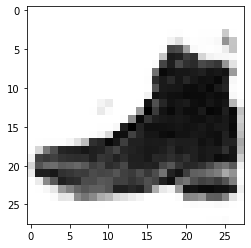

generation 진행 : 0
tensor(12.2566)
tensor([4])
tensor(12.2526)
tensor([4])
tensor(12.2473)
tensor([4])
tensor(12.2468)
tensor([4])
tensor(12.2401)
tensor([4])
tensor(12.2384)
tensor([4])
tensor(12.2355)
tensor([4])
tensor(12.2291)
tensor([4])
tensor(12.2246)
tensor([4])
tensor(12.2211)
tensor([4])
generation 진행 : 10
tensor(12.2200)
tensor([4])
tensor(12.2190)
tensor([4])
tensor(12.2129)
tensor([4])
tensor(12.2103)
tensor([4])
tensor(12.2056)
tensor([4])
tensor(12.2006)
tensor([4])
tensor(12.1991)
tensor([4])
tensor(12.1961)
tensor([4])
tensor(12.1920)
tensor([4])
tensor(12.1892)
tensor([4])
generation 진행 : 20
tensor(12.1860)
tensor([4])
tensor(12.1802)
tensor([4])
tensor(12.1737)
tensor([4])
tensor(12.1696)
tensor([4])
tensor(12.1671)
tensor([4])
tensor(12.1637)
tensor([4])
tensor(12.1604)
tensor([4])
tensor(12.1593)
tensor([4])
tensor(12.1542)
tensor([4])
tensor(12.1482)
tensor([4])
바뀐 숫자 예측은 tensor([4])
원래 숫자 예측은  tensor([5]) 인덱스는 9086


<Figure size 432x288 with 0 Axes>

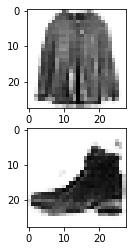

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
torch.Size([1, 1, 28, 28])
 generate


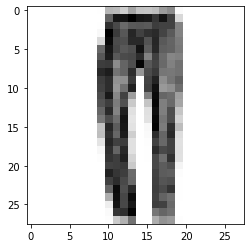

generation 진행 : 0
tensor(11.5243)
tensor([5])
tensor(11.5181)
tensor([5])
tensor(11.5162)
tensor([5])
tensor(11.5121)
tensor([5])
tensor(11.5116)
tensor([5])
tensor(11.5055)
tensor([5])
tensor(11.4989)
tensor([5])
tensor(11.4959)
tensor([5])
tensor(11.4915)
tensor([5])
tensor(11.4881)
tensor([5])
generation 진행 : 10
tensor(11.4847)
tensor([5])
tensor(11.4823)
tensor([5])
tensor(11.4779)
tensor([5])
tensor(11.4740)
tensor([5])
tensor(11.4695)
tensor([5])
tensor(11.4660)
tensor([5])
tensor(11.4643)
tensor([5])
tensor(11.4612)
tensor([5])
tensor(11.4603)
tensor([5])
tensor(11.4558)
tensor([5])
generation 진행 : 20
tensor(11.4503)
tensor([5])
tensor(11.4397)
tensor([5])
tensor(11.4355)
tensor([5])
tensor(11.4312)
tensor([5])
tensor(11.4260)
tensor([5])
tensor(11.4258)
tensor([5])
tensor(11.4219)
tensor([5])
tensor(11.4193)
tensor([5])
tensor(11.4152)
tensor([5])
tensor(11.4125)
tensor([5])
바뀐 숫자 예측은 tensor([5])
원래 숫자 예측은  tensor([8]) 인덱스는 474


<Figure size 432x288 with 0 Axes>

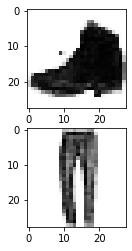

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


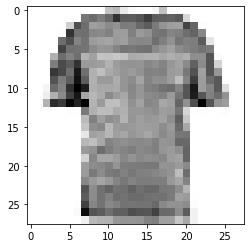

generation 진행 : 0
tensor(11.8102)
tensor([3])
tensor(11.8058)
tensor([3])
tensor(11.8019)
tensor([3])
tensor(11.7993)
tensor([3])
tensor(11.7975)
tensor([3])
tensor(11.7959)
tensor([3])
tensor(11.7887)
tensor([3])
tensor(11.7818)
tensor([3])
tensor(11.7761)
tensor([3])
tensor(11.7729)
tensor([3])
generation 진행 : 10
tensor(11.7661)
tensor([3])
tensor(11.7598)
tensor([3])
tensor(11.7546)
tensor([3])
tensor(11.7478)
tensor([3])
tensor(11.7436)
tensor([3])
tensor(11.7399)
tensor([3])
tensor(11.7330)
tensor([3])
tensor(11.7308)
tensor([3])
tensor(11.7251)
tensor([3])
tensor(11.7233)
tensor([3])
generation 진행 : 20
tensor(11.7208)
tensor([3])
tensor(11.7186)
tensor([3])
tensor(11.7137)
tensor([3])
tensor(11.7107)
tensor([3])
tensor(11.7027)
tensor([3])
tensor(11.6980)
tensor([3])
tensor(11.6933)
tensor([3])
tensor(11.6909)
tensor([3])
tensor(11.6893)
tensor([3])
tensor(11.6878)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([0]) 인덱스는 5170


<Figure size 432x288 with 0 Axes>

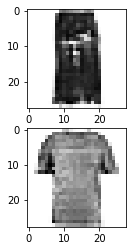

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


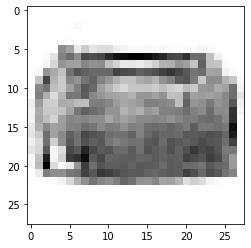

generation 진행 : 0
tensor(12.1973)
tensor([5])
tensor(12.1966)
tensor([5])
tensor(12.1909)
tensor([5])
tensor(12.1886)
tensor([5])
tensor(12.1858)
tensor([5])
tensor(12.1837)
tensor([5])
tensor(12.1806)
tensor([5])
tensor(12.1757)
tensor([5])
tensor(12.1710)
tensor([5])
generation 진행 : 10
tensor(12.1638)
tensor([5])
tensor(12.1635)
tensor([5])
tensor(12.1597)
tensor([5])
tensor(12.1532)
tensor([5])
tensor(12.1454)
tensor([5])
tensor(12.1399)
tensor([5])
tensor(12.1360)
tensor([5])
tensor(12.1328)
tensor([5])
tensor(12.1292)
tensor([5])
generation 진행 : 20
tensor(12.1224)
tensor([5])
tensor(12.1211)
tensor([5])
tensor(12.1181)
tensor([5])
tensor(12.1138)
tensor([5])
tensor(12.1118)
tensor([5])
tensor(12.1077)
tensor([5])
tensor(12.1015)
tensor([5])
tensor(12.0959)
tensor([5])
tensor(12.0939)
tensor([5])
tensor(12.0901)
tensor([5])
바뀐 숫자 예측은 tensor([5])
원래 숫자 예측은  tensor([8]) 인덱스는 3227


<Figure size 432x288 with 0 Axes>

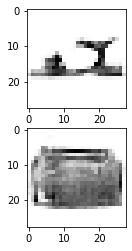

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


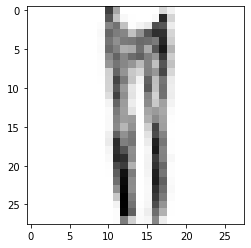

generation 진행 : 0
tensor(13.5075)
tensor([4])
tensor(13.4985)
tensor([4])
tensor(13.4942)
tensor([4])
tensor(13.4914)
tensor([4])
tensor(13.4871)
tensor([4])
tensor(13.4857)
tensor([4])
tensor(13.4775)
tensor([4])
tensor(13.4714)
tensor([4])
tensor(13.4666)
tensor([4])
generation 진행 : 10
tensor(13.4623)
tensor([4])
tensor(13.4575)
tensor([4])
tensor(13.4519)
tensor([4])
tensor(13.4502)
tensor([4])
tensor(13.4464)
tensor([4])
tensor(13.4400)
tensor([4])
tensor(13.4377)
tensor([4])
tensor(13.4326)
tensor([4])
tensor(13.4306)
tensor([4])
tensor(13.4268)
tensor([4])
generation 진행 : 20
tensor(13.4202)
tensor([4])
tensor(13.4167)
tensor([4])
tensor(13.4123)
tensor([4])
tensor(13.4073)
tensor([4])
tensor(13.4046)
tensor([4])
tensor(13.4002)
tensor([4])
tensor(13.3965)
tensor([4])
tensor(13.3873)
tensor([4])
tensor(13.3841)
tensor([4])
tensor(13.3807)
tensor([4])
바뀐 숫자 예측은 tensor([4])
원래 숫자 예측은  tensor([8]) 인덱스는 7040


<Figure size 432x288 with 0 Axes>

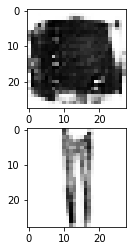

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


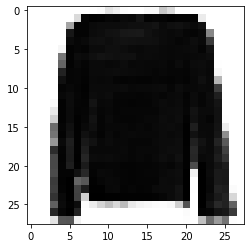

generation 진행 : 0
tensor(12.0994)
tensor([8])
tensor(12.0957)
tensor([8])
tensor(12.0857)
tensor([8])
tensor(12.0819)
tensor([8])
tensor(12.0764)
tensor([8])
tensor(12.0730)
tensor([8])
tensor(12.0696)
tensor([8])
tensor(12.0658)
tensor([8])
tensor(12.0570)
tensor([8])
tensor(12.0554)
tensor([8])
generation 진행 : 10
tensor(12.0508)
tensor([8])
tensor(12.0458)
tensor([8])
tensor(12.0442)
tensor([8])
tensor(12.0391)
tensor([8])
tensor(12.0334)
tensor([8])
tensor(12.0271)
tensor([8])
tensor(12.0231)
tensor([8])
tensor(12.0172)
tensor([8])
tensor(12.0145)
tensor([8])
tensor(12.0114)
tensor([8])
generation 진행 : 20
tensor(12.0090)
tensor([8])
tensor(12.0016)
tensor([8])
tensor(11.9954)
tensor([8])
tensor(11.9915)
tensor([8])
tensor(11.9869)
tensor([8])
tensor(11.9857)
tensor([8])
tensor(11.9840)
tensor([8])
tensor(11.9815)
tensor([8])
tensor(11.9784)
tensor([8])
tensor(11.9744)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([4]) 인덱스는 3860


<Figure size 432x288 with 0 Axes>

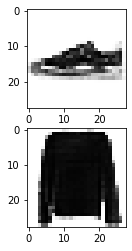

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


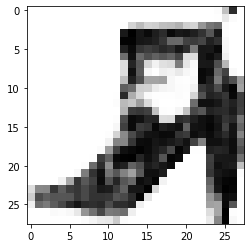

generation 진행 : 0
tensor(11.1135)
tensor([8])
tensor(11.1099)
tensor([8])
tensor(11.1075)
tensor([8])
tensor(11.1012)
tensor([8])
tensor(11.0991)
tensor([8])
tensor(11.0935)
tensor([8])
tensor(11.0894)
tensor([8])
tensor(11.0880)
tensor([8])
tensor(11.0860)
tensor([8])
generation 진행 : 10
tensor(11.0816)
tensor([8])
tensor(11.0791)
tensor([8])
tensor(11.0750)
tensor([8])
tensor(11.0700)
tensor([8])
tensor(11.0656)
tensor([8])
tensor(11.0607)
tensor([8])
tensor(11.0598)
tensor([8])
tensor(11.0569)
tensor([8])
tensor(11.0503)
tensor([8])
tensor(11.0441)
tensor([8])
generation 진행 : 20
tensor(11.0376)
tensor([8])
tensor(11.0342)
tensor([8])
tensor(11.0276)
tensor([8])
tensor(11.0253)
tensor([8])
tensor(11.0177)
tensor([8])
tensor(11.0158)
tensor([8])
tensor(11.0088)
tensor([8])
tensor(11.0070)
tensor([8])
tensor(11.0044)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([5]) 인덱스는 8259


<Figure size 432x288 with 0 Axes>

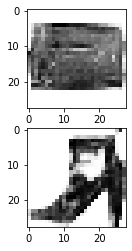

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


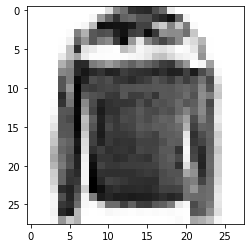

generation 진행 : 0
tensor(12.7516)
tensor([6])
tensor(12.7497)
tensor([6])
tensor(12.7439)
tensor([6])
tensor(12.7412)
tensor([6])
tensor(12.7376)
tensor([6])
tensor(12.7331)
tensor([6])
tensor(12.7294)
tensor([6])
tensor(12.7248)
tensor([6])
tensor(12.7182)
tensor([6])
tensor(12.7157)
tensor([6])
generation 진행 : 10
tensor(12.7108)
tensor([6])
tensor(12.7042)
tensor([6])
tensor(12.7001)
tensor([6])
tensor(12.6975)
tensor([6])
tensor(12.6931)
tensor([6])
tensor(12.6900)
tensor([6])
tensor(12.6856)
tensor([6])
tensor(12.6821)
tensor([6])
tensor(12.6764)
tensor([6])
tensor(12.6731)
tensor([6])
generation 진행 : 20
tensor(12.6694)
tensor([6])
tensor(12.6672)
tensor([6])
tensor(12.6650)
tensor([6])
tensor(12.6606)
tensor([6])
tensor(12.6581)
tensor([6])
tensor(12.6509)
tensor([6])
tensor(12.6447)
tensor([6])
tensor(12.6402)
tensor([6])
tensor(12.6358)
tensor([6])
tensor(12.6277)
tensor([6])
바뀐 숫자 예측은 tensor([6])
원래 숫자 예측은  tensor([4]) 인덱스는 2917


<Figure size 432x288 with 0 Axes>

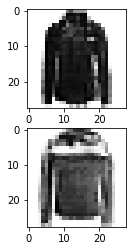

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


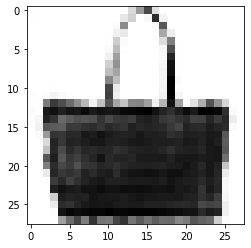

generation 진행 : 0
tensor(12.1303)
tensor([5])
tensor(12.1266)
tensor([5])
tensor(12.1203)
tensor([5])
tensor(12.1188)
tensor([5])
tensor(12.1154)
tensor([5])
tensor(12.1132)
tensor([5])
tensor(12.1083)
tensor([5])
tensor(12.1055)
tensor([5])
tensor(12.0996)
tensor([5])
tensor(12.0995)
tensor([5])
generation 진행 : 10
tensor(12.0924)
tensor([5])
tensor(12.0876)
tensor([5])
tensor(12.0822)
tensor([5])
tensor(12.0789)
tensor([5])
tensor(12.0695)
tensor([5])
tensor(12.0671)
tensor([5])
tensor(12.0634)
tensor([5])
tensor(12.0596)
tensor([5])
tensor(12.0571)
tensor([5])
tensor(12.0539)
tensor([5])
generation 진행 : 20
tensor(12.0537)
tensor([5])
tensor(12.0507)
tensor([5])
tensor(12.0473)
tensor([5])
tensor(12.0406)
tensor([5])
tensor(12.0360)
tensor([5])
tensor(12.0333)
tensor([5])
tensor(12.0301)
tensor([5])
tensor(12.0267)
tensor([5])
tensor(12.0219)
tensor([5])
바뀐 숫자 예측은 tensor([5])
원래 숫자 예측은  tensor([8]) 인덱스는 17


<Figure size 432x288 with 0 Axes>

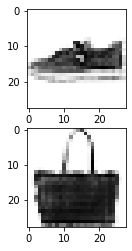

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


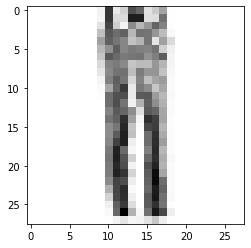

generation 진행 : 0
tensor(12.7872)
tensor([5])
tensor(12.7846)
tensor([5])
tensor(12.7802)
tensor([5])
tensor(12.7753)
tensor([5])
tensor(12.7726)
tensor([5])
tensor(12.7666)
tensor([5])
tensor(12.7620)
tensor([5])
tensor(12.7615)
tensor([5])
tensor(12.7569)
tensor([5])
tensor(12.7549)
tensor([5])
generation 진행 : 10
tensor(12.7509)
tensor([5])
tensor(12.7475)
tensor([5])
tensor(12.7446)
tensor([5])
tensor(12.7421)
tensor([5])
tensor(12.7378)
tensor([5])
tensor(12.7324)
tensor([5])
tensor(12.7298)
tensor([5])
tensor(12.7263)
tensor([5])
tensor(12.7209)
tensor([5])
tensor(12.7168)
tensor([5])
generation 진행 : 20
tensor(12.7157)
tensor([5])
tensor(12.7098)
tensor([5])
tensor(12.7047)
tensor([5])
tensor(12.7014)
tensor([5])
tensor(12.6986)
tensor([5])
tensor(12.6973)
tensor([5])
tensor(12.6945)
tensor([5])
tensor(12.6936)
tensor([5])
tensor(12.6894)
tensor([5])
tensor(12.6871)
tensor([5])
바뀐 숫자 예측은 tensor([5])
원래 숫자 예측은  tensor([8]) 인덱스는 7013


<Figure size 432x288 with 0 Axes>

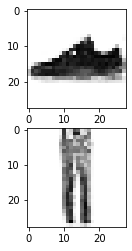

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


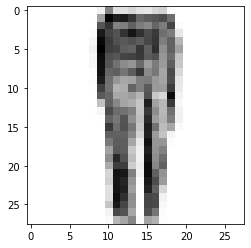

generation 진행 : 0
tensor(12.3140)
tensor([1])
tensor(12.3100)
tensor([1])
tensor(12.3067)
tensor([1])
tensor(12.3006)
tensor([1])
tensor(12.2974)
tensor([1])
tensor(12.2950)
tensor([1])
tensor(12.2912)
tensor([1])
tensor(12.2890)
tensor([1])
tensor(12.2842)
tensor([1])
tensor(12.2805)
tensor([1])
generation 진행 : 10
tensor(12.2760)
tensor([1])
tensor(12.2697)
tensor([1])
tensor(12.2669)
tensor([1])
tensor(12.2651)
tensor([1])
tensor(12.2587)
tensor([1])
tensor(12.2562)
tensor([1])
tensor(12.2489)
tensor([1])
tensor(12.2406)
tensor([1])
tensor(12.2366)
tensor([1])
tensor(12.2350)
tensor([1])
generation 진행 : 20
tensor(12.2307)
tensor([1])
tensor(12.2264)
tensor([1])
tensor(12.2225)
tensor([1])
tensor(12.2173)
tensor([1])
tensor(12.2098)
tensor([1])
tensor(12.2063)
tensor([1])
tensor(12.2016)
tensor([1])
tensor(12.1963)
tensor([1])
tensor(12.1944)
tensor([1])
tensor(12.1916)
tensor([1])
바뀐 숫자 예측은 tensor([1])
원래 숫자 예측은  tensor([8]) 인덱스는 5701


<Figure size 432x288 with 0 Axes>

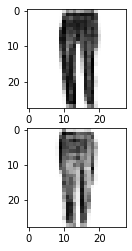

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


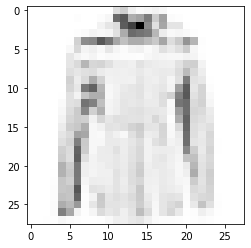

generation 진행 : 0
tensor(12.0551)
tensor([3])
tensor(12.0518)
tensor([3])
tensor(12.0493)
tensor([3])
tensor(12.0486)
tensor([3])
tensor(12.0452)
tensor([3])
tensor(12.0421)
tensor([3])
tensor(12.0386)
tensor([3])
tensor(12.0338)
tensor([3])
tensor(12.0287)
tensor([3])
tensor(12.0248)
tensor([3])
generation 진행 : 10
tensor(12.0218)
tensor([3])
tensor(12.0178)
tensor([3])
tensor(12.0104)
tensor([3])
tensor(12.0073)
tensor([3])
tensor(12.0001)
tensor([3])
tensor(11.9953)
tensor([3])
tensor(11.9943)
tensor([3])
tensor(11.9889)
tensor([3])
tensor(11.9809)
tensor([3])
generation 진행 : 20
tensor(11.9766)
tensor([3])
tensor(11.9736)
tensor([3])
tensor(11.9698)
tensor([3])
tensor(11.9621)
tensor([3])
tensor(11.9612)
tensor([3])
tensor(11.9545)
tensor([3])
tensor(11.9486)
tensor([3])
tensor(11.9441)
tensor([3])
tensor(11.9379)
tensor([3])
tensor(11.9334)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([8]) 인덱스는 9198


<Figure size 432x288 with 0 Axes>

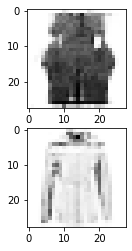

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


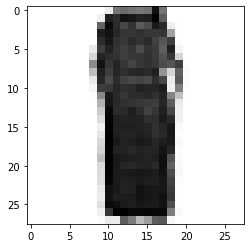

generation 진행 : 0
tensor(11.0900)
tensor([5])
tensor(11.0889)
tensor([5])
tensor(11.0833)
tensor([5])
tensor(11.0794)
tensor([5])
tensor(11.0766)
tensor([5])
tensor(11.0713)
tensor([5])
tensor(11.0673)
tensor([5])
tensor(11.0617)
tensor([5])
tensor(11.0578)
tensor([5])
generation 진행 : 10
tensor(11.0560)
tensor([5])
tensor(11.0531)
tensor([5])
tensor(11.0452)
tensor([5])
tensor(11.0441)
tensor([5])
tensor(11.0403)
tensor([5])
tensor(11.0325)
tensor([5])
tensor(11.0271)
tensor([5])
tensor(11.0238)
tensor([5])
tensor(11.0196)
tensor([5])
tensor(11.0188)
tensor([5])
generation 진행 : 20
tensor(11.0133)
tensor([5])
tensor(11.0085)
tensor([5])
tensor(11.0050)
tensor([5])
tensor(11.0022)
tensor([5])
tensor(10.9991)
tensor([5])
tensor(10.9940)
tensor([5])
tensor(10.9886)
tensor([5])
tensor(10.9845)
tensor([5])
tensor(10.9793)
tensor([5])
tensor(10.9774)
tensor([5])
바뀐 숫자 예측은 tensor([5])
원래 숫자 예측은  tensor([3]) 인덱스는 1248


<Figure size 432x288 with 0 Axes>

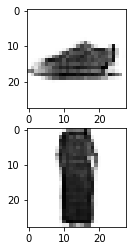

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


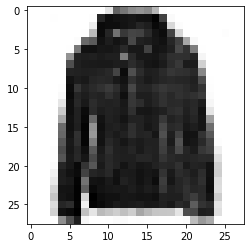

generation 진행 : 0
tensor(11.2745)
tensor([3])
tensor(11.2701)
tensor([3])
tensor(11.2629)
tensor([3])
tensor(11.2598)
tensor([3])
tensor(11.2573)
tensor([3])
tensor(11.2548)
tensor([3])
tensor(11.2518)
tensor([3])
tensor(11.2484)
tensor([3])
tensor(11.2483)
tensor([3])
tensor(11.2447)
tensor([3])
generation 진행 : 10
tensor(11.2366)
tensor([3])
tensor(11.2310)
tensor([3])
tensor(11.2271)
tensor([3])
tensor(11.2211)
tensor([3])
tensor(11.2196)
tensor([3])
tensor(11.2163)
tensor([3])
tensor(11.2116)
tensor([3])
tensor(11.2052)
tensor([3])
tensor(11.2051)
tensor([3])
generation 진행 : 20
tensor(11.2021)
tensor([3])
tensor(11.2004)
tensor([3])
tensor(11.1941)
tensor([3])
tensor(11.1899)
tensor([3])
tensor(11.1843)
tensor([3])
tensor(11.1775)
tensor([3])
tensor(11.1751)
tensor([3])
tensor(11.1727)
tensor([3])
tensor(11.1690)
tensor([3])
tensor(11.1640)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([4]) 인덱스는 3753


<Figure size 432x288 with 0 Axes>

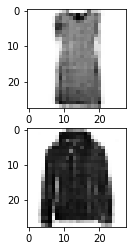

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


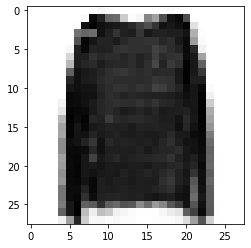

generation 진행 : 0
tensor(12.2744)
tensor([6])
tensor(12.2732)
tensor([6])
tensor(12.2682)
tensor([6])
tensor(12.2617)
tensor([6])
tensor(12.2567)
tensor([6])
tensor(12.2543)
tensor([6])
tensor(12.2503)
tensor([6])
tensor(12.2482)
tensor([6])
tensor(12.2422)
tensor([6])
generation 진행 : 10
tensor(12.2390)
tensor([6])
tensor(12.2347)
tensor([6])
tensor(12.2298)
tensor([6])
tensor(12.2258)
tensor([6])
tensor(12.2193)
tensor([6])
tensor(12.2136)
tensor([4])
tensor(12.2064)
tensor([4])
tensor(12.2008)
tensor([4])
tensor(12.1969)
tensor([4])
generation 진행 : 20
tensor(12.1917)
tensor([4])
tensor(12.1887)
tensor([4])
tensor(12.1880)
tensor([4])
tensor(12.1822)
tensor([4])
tensor(12.1783)
tensor([4])
tensor(12.1756)
tensor([4])
tensor(12.1727)
tensor([4])
tensor(12.1698)
tensor([4])
tensor(12.1644)
tensor([4])
바뀐 숫자 예측은 tensor([4])
원래 숫자 예측은  tensor([3]) 인덱스는 6209


<Figure size 432x288 with 0 Axes>

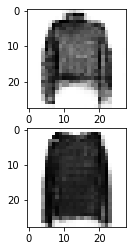

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


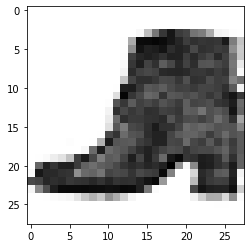

generation 진행 : 0
tensor(13.0275)
tensor([3])
tensor(13.0220)
tensor([3])
tensor(13.0202)
tensor([3])
tensor(13.0114)
tensor([3])
tensor(13.0077)
tensor([3])
tensor(13.0036)
tensor([3])
tensor(13.0000)
tensor([3])
tensor(12.9959)
tensor([3])
tensor(12.9913)
tensor([3])
tensor(12.9836)
tensor([3])
generation 진행 : 10
tensor(12.9821)
tensor([3])
tensor(12.9797)
tensor([3])
tensor(12.9783)
tensor([3])
tensor(12.9771)
tensor([3])
tensor(12.9751)
tensor([3])
tensor(12.9726)
tensor([3])
tensor(12.9715)
tensor([3])
tensor(12.9674)
tensor([3])
tensor(12.9622)
tensor([3])
generation 진행 : 20
tensor(12.9593)
tensor([3])
tensor(12.9581)
tensor([3])
tensor(12.9512)
tensor([3])
tensor(12.9489)
tensor([3])
tensor(12.9455)
tensor([3])
tensor(12.9430)
tensor([3])
tensor(12.9399)
tensor([3])
tensor(12.9374)
tensor([3])
tensor(12.9321)
tensor([3])
tensor(12.9234)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([9]) 인덱스는 832


<Figure size 432x288 with 0 Axes>

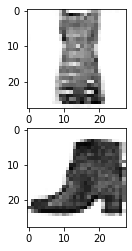

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


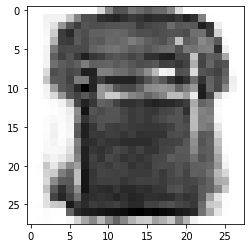

generation 진행 : 0
tensor(12.4330)
tensor([9])
tensor(12.4287)
tensor([9])
tensor(12.4240)
tensor([9])
tensor(12.4183)
tensor([9])
tensor(12.4128)
tensor([9])
tensor(12.4109)
tensor([9])
tensor(12.4076)
tensor([9])
tensor(12.4020)
tensor([9])
tensor(12.3983)
tensor([9])
tensor(12.3935)
tensor([9])
generation 진행 : 10
tensor(12.3912)
tensor([9])
tensor(12.3903)
tensor([9])
tensor(12.3822)
tensor([9])
tensor(12.3741)
tensor([9])
tensor(12.3714)
tensor([9])
tensor(12.3682)
tensor([9])
tensor(12.3652)
tensor([9])
tensor(12.3589)
tensor([9])
tensor(12.3577)
tensor([9])
tensor(12.3539)
tensor([9])
generation 진행 : 20
tensor(12.3524)
tensor([9])
tensor(12.3480)
tensor([9])
tensor(12.3455)
tensor([9])
tensor(12.3374)
tensor([9])
tensor(12.3334)
tensor([9])
tensor(12.3308)
tensor([9])
tensor(12.3231)
tensor([9])
tensor(12.3165)
tensor([9])
tensor(12.3125)
tensor([9])
바뀐 숫자 예측은 tensor([9])
원래 숫자 예측은  tensor([0]) 인덱스는 2255


<Figure size 432x288 with 0 Axes>

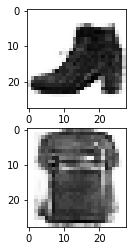

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


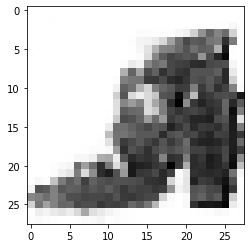

generation 진행 : 0
tensor(11.6772)
tensor([6])
tensor(11.6725)
tensor([6])
tensor(11.6675)
tensor([6])
tensor(11.6638)
tensor([6])
tensor(11.6582)
tensor([6])
tensor(11.6572)
tensor([6])
tensor(11.6503)
tensor([6])
tensor(11.6465)
tensor([6])
tensor(11.6435)
tensor([6])
tensor(11.6395)
tensor([6])
generation 진행 : 10
tensor(11.6366)
tensor([6])
tensor(11.6344)
tensor([6])
tensor(11.6315)
tensor([6])
tensor(11.6275)
tensor([6])
tensor(11.6213)
tensor([6])
tensor(11.6187)
tensor([6])
tensor(11.6117)
tensor([6])
tensor(11.6076)
tensor([6])
tensor(11.6033)
tensor([6])
tensor(11.5983)
tensor([6])
generation 진행 : 20
tensor(11.5954)
tensor([6])
tensor(11.5891)
tensor([6])
tensor(11.5837)
tensor([6])
tensor(11.5820)
tensor([6])
tensor(11.5770)
tensor([6])
tensor(11.5711)
tensor([6])
tensor(11.5670)
tensor([6])
tensor(11.5634)
tensor([6])
tensor(11.5575)
tensor([6])
바뀐 숫자 예측은 tensor([6])
원래 숫자 예측은  tensor([5]) 인덱스는 1565


<Figure size 432x288 with 0 Axes>

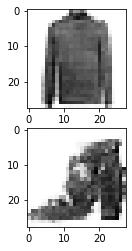

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


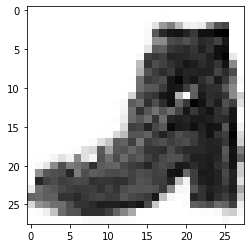

generation 진행 : 0
tensor(12.9610)
tensor([8])
tensor(12.9577)
tensor([8])
tensor(12.9554)
tensor([8])
tensor(12.9519)
tensor([8])
tensor(12.9461)
tensor([8])
tensor(12.9412)
tensor([8])
tensor(12.9392)
tensor([8])
tensor(12.9363)
tensor([8])
tensor(12.9319)
tensor([8])
tensor(12.9254)
tensor([8])
generation 진행 : 10
tensor(12.9214)
tensor([8])
tensor(12.9196)
tensor([8])
tensor(12.9153)
tensor([8])
tensor(12.9114)
tensor([8])
tensor(12.9077)
tensor([8])
tensor(12.9027)
tensor([8])
tensor(12.8976)
tensor([8])
tensor(12.8931)
tensor([8])
tensor(12.8914)
tensor([8])
generation 진행 : 20
tensor(12.8887)
tensor([8])
tensor(12.8869)
tensor([8])
tensor(12.8832)
tensor([8])
tensor(12.8793)
tensor([8])
tensor(12.8756)
tensor([8])
tensor(12.8721)
tensor([8])
tensor(12.8687)
tensor([8])
tensor(12.8666)
tensor([8])
tensor(12.8659)
tensor([8])
tensor(12.8602)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([5]) 인덱스는 9457


<Figure size 432x288 with 0 Axes>

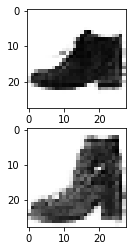

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


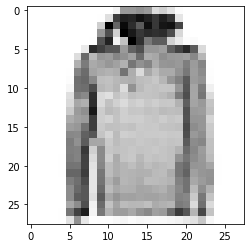

generation 진행 : 0
tensor(13.6071)
tensor([8])
tensor(13.6020)
tensor([8])
tensor(13.5982)
tensor([8])
tensor(13.5945)
tensor([8])
tensor(13.5909)
tensor([8])
tensor(13.5852)
tensor([8])
tensor(13.5810)
tensor([8])
tensor(13.5782)
tensor([8])
tensor(13.5768)
tensor([8])
tensor(13.5758)
tensor([8])
generation 진행 : 10
tensor(13.5711)
tensor([8])
tensor(13.5673)
tensor([8])
tensor(13.5612)
tensor([8])
tensor(13.5558)
tensor([8])
tensor(13.5558)
tensor([8])
tensor(13.5495)
tensor([8])
tensor(13.5445)
tensor([8])
tensor(13.5395)
tensor([8])
tensor(13.5362)
tensor([8])
generation 진행 : 20
tensor(13.5337)
tensor([8])
tensor(13.5336)
tensor([8])
tensor(13.5302)
tensor([8])
tensor(13.5228)
tensor([8])
tensor(13.5174)
tensor([8])
tensor(13.5096)
tensor([8])
tensor(13.5027)
tensor([8])
tensor(13.5015)
tensor([8])
tensor(13.4957)
tensor([8])
tensor(13.4942)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([5]) 인덱스는 2291


<Figure size 432x288 with 0 Axes>

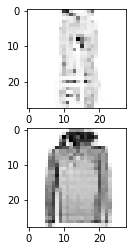

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


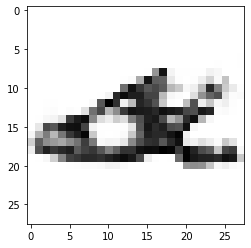

generation 진행 : 0
tensor(13.3103)
tensor([3])
tensor(13.3090)
tensor([3])
tensor(13.3048)
tensor([3])
tensor(13.3015)
tensor([3])
tensor(13.2956)
tensor([3])
tensor(13.2911)
tensor([3])
tensor(13.2874)
tensor([3])
tensor(13.2830)
tensor([3])
tensor(13.2820)
tensor([3])
tensor(13.2769)
tensor([3])
generation 진행 : 10
tensor(13.2729)
tensor([3])
tensor(13.2636)
tensor([3])
tensor(13.2596)
tensor([3])
tensor(13.2562)
tensor([3])
tensor(13.2533)
tensor([3])
tensor(13.2510)
tensor([3])
tensor(13.2411)
tensor([3])
tensor(13.2374)
tensor([3])
tensor(13.2323)
tensor([3])
tensor(13.2289)
tensor([3])
generation 진행 : 20
tensor(13.2276)
tensor([3])
tensor(13.2267)
tensor([3])
tensor(13.2218)
tensor([3])
tensor(13.2179)
tensor([3])
tensor(13.2167)
tensor([3])
tensor(13.2155)
tensor([3])
tensor(13.2114)
tensor([3])
tensor(13.2076)
tensor([3])
tensor(13.2008)
tensor([3])
tensor(13.1940)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([5]) 인덱스는 826


<Figure size 432x288 with 0 Axes>

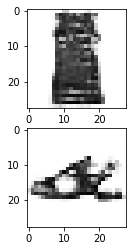

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


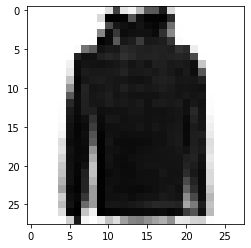

generation 진행 : 0
tensor(11.2711)
tensor([4])
tensor(11.2664)
tensor([4])
tensor(11.2625)
tensor([4])
tensor(11.2596)
tensor([4])
tensor(11.2548)
tensor([4])
tensor(11.2528)
tensor([4])
tensor(11.2461)
tensor([4])
tensor(11.2409)
tensor([4])
tensor(11.2374)
tensor([4])
tensor(11.2339)
tensor([4])
generation 진행 : 10
tensor(11.2283)
tensor([4])
tensor(11.2212)
tensor([4])
tensor(11.2124)
tensor([4])
tensor(11.2082)
tensor([4])
tensor(11.2007)
tensor([4])
tensor(11.1952)
tensor([4])
tensor(11.1891)
tensor([4])
tensor(11.1844)
tensor([4])
tensor(11.1781)
tensor([4])
generation 진행 : 20
tensor(11.1763)
tensor([4])
tensor(11.1720)
tensor([4])
tensor(11.1675)
tensor([4])
tensor(11.1642)
tensor([4])
tensor(11.1613)
tensor([4])
tensor(11.1593)
tensor([4])
tensor(11.1527)
tensor([4])
tensor(11.1450)
tensor([4])
tensor(11.1436)
tensor([4])
바뀐 숫자 예측은 tensor([4])
원래 숫자 예측은  tensor([3]) 인덱스는 7219


<Figure size 432x288 with 0 Axes>

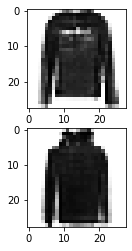

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


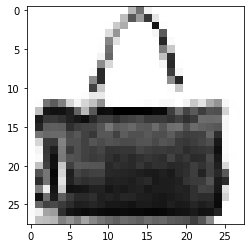

generation 진행 : 0
tensor(11.9849)
tensor([3])
tensor(11.9817)
tensor([3])
tensor(11.9771)
tensor([3])
tensor(11.9760)
tensor([3])
tensor(11.9731)
tensor([3])
tensor(11.9652)
tensor([3])
tensor(11.9601)
tensor([3])
tensor(11.9584)
tensor([3])
tensor(11.9537)
tensor([3])
tensor(11.9501)
tensor([3])
generation 진행 : 10
tensor(11.9465)
tensor([3])
tensor(11.9436)
tensor([3])
tensor(11.9415)
tensor([3])
tensor(11.9349)
tensor([3])
tensor(11.9313)
tensor([3])
tensor(11.9293)
tensor([3])
tensor(11.9259)
tensor([3])
tensor(11.9244)
tensor([3])
tensor(11.9213)
tensor([3])
tensor(11.9170)
tensor([3])
generation 진행 : 20
tensor(11.9101)
tensor([3])
tensor(11.9095)
tensor([3])
tensor(11.9055)
tensor([3])
tensor(11.9034)
tensor([3])
tensor(11.9006)
tensor([3])
tensor(11.8994)
tensor([3])
tensor(11.8965)
tensor([3])
tensor(11.8918)
tensor([3])
tensor(11.8842)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([8]) 인덱스는 7667


<Figure size 432x288 with 0 Axes>

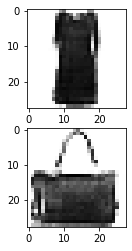

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


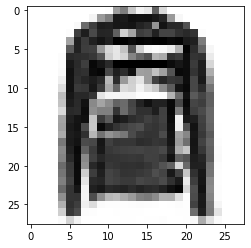

generation 진행 : 0
tensor(12.2856)
tensor([3])
tensor(12.2820)
tensor([3])
tensor(12.2759)
tensor([3])
tensor(12.2728)
tensor([3])
tensor(12.2672)
tensor([3])
tensor(12.2623)
tensor([3])
tensor(12.2582)
tensor([3])
tensor(12.2554)
tensor([3])
tensor(12.2507)
tensor([3])
tensor(12.2452)
tensor([3])
generation 진행 : 10
tensor(12.2421)
tensor([3])
tensor(12.2358)
tensor([3])
tensor(12.2324)
tensor([3])
tensor(12.2321)
tensor([3])
tensor(12.2270)
tensor([3])
tensor(12.2232)
tensor([3])
tensor(12.2202)
tensor([3])
tensor(12.2184)
tensor([3])
tensor(12.2142)
tensor([3])
generation 진행 : 20
tensor(12.2077)
tensor([3])
tensor(12.2039)
tensor([3])
tensor(12.2007)
tensor([3])
tensor(12.1957)
tensor([3])
tensor(12.1906)
tensor([3])
tensor(12.1852)
tensor([3])
tensor(12.1816)
tensor([3])
tensor(12.1787)
tensor([3])
tensor(12.1774)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([6]) 인덱스는 6254


<Figure size 432x288 with 0 Axes>

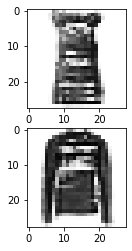

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


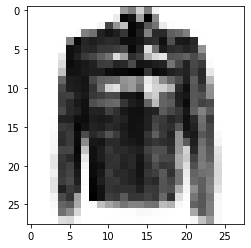

generation 진행 : 0
tensor(12.9243)
tensor([5])
tensor(12.9214)
tensor([5])
tensor(12.9171)
tensor([5])
tensor(12.9149)
tensor([5])
tensor(12.9113)
tensor([5])
tensor(12.9091)
tensor([5])
tensor(12.9068)
tensor([5])
tensor(12.9060)
tensor([5])
tensor(12.9041)
tensor([5])
tensor(12.9001)
tensor([5])
generation 진행 : 10
tensor(12.8934)
tensor([5])
tensor(12.8913)
tensor([5])
tensor(12.8877)
tensor([5])
tensor(12.8811)
tensor([5])
tensor(12.8772)
tensor([5])
tensor(12.8723)
tensor([5])
tensor(12.8697)
tensor([5])
tensor(12.8643)
tensor([5])
tensor(12.8594)
tensor([5])
generation 진행 : 20
tensor(12.8557)
tensor([5])
tensor(12.8525)
tensor([5])
tensor(12.8461)
tensor([5])
tensor(12.8414)
tensor([5])
tensor(12.8381)
tensor([5])
tensor(12.8321)
tensor([5])
tensor(12.8274)
tensor([5])
tensor(12.8233)
tensor([5])
tensor(12.8222)
tensor([5])
tensor(12.8186)
tensor([5])
바뀐 숫자 예측은 tensor([5])
원래 숫자 예측은  tensor([4]) 인덱스는 5854


<Figure size 432x288 with 0 Axes>

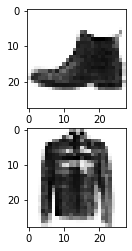

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


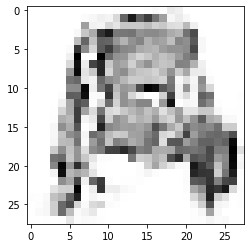

generation 진행 : 0
tensor(12.6141)
tensor([5])
tensor(12.6118)
tensor([5])
tensor(12.6059)
tensor([5])
tensor(12.6025)
tensor([5])
tensor(12.6001)
tensor([5])
tensor(12.5962)
tensor([5])
tensor(12.5909)
tensor([5])
tensor(12.5872)
tensor([5])
tensor(12.5813)
tensor([5])
tensor(12.5760)
tensor([5])
generation 진행 : 10
tensor(12.5687)
tensor([5])
tensor(12.5653)
tensor([5])
tensor(12.5592)
tensor([5])
tensor(12.5565)
tensor([5])
tensor(12.5507)
tensor([5])
tensor(12.5455)
tensor([5])
tensor(12.5422)
tensor([5])
tensor(12.5393)
tensor([5])
tensor(12.5343)
tensor([5])
tensor(12.5306)
tensor([5])
generation 진행 : 20
tensor(12.5277)
tensor([5])
tensor(12.5220)
tensor([5])
tensor(12.5168)
tensor([5])
tensor(12.5125)
tensor([5])
tensor(12.5050)
tensor([5])
tensor(12.4998)
tensor([5])
tensor(12.4939)
tensor([5])
tensor(12.4933)
tensor([5])
tensor(12.4887)
tensor([5])
tensor(12.4841)
tensor([5])
바뀐 숫자 예측은 tensor([5])
원래 숫자 예측은  tensor([8]) 인덱스는 1360


<Figure size 432x288 with 0 Axes>

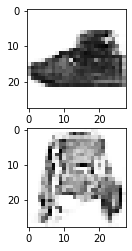

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


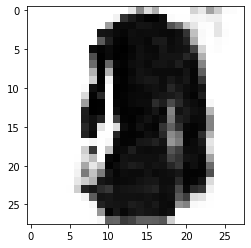

generation 진행 : 0
tensor(11.2878)
tensor([0])
tensor(11.2847)
tensor([0])
tensor(11.2807)
tensor([0])
tensor(11.2724)
tensor([0])
tensor(11.2715)
tensor([0])
tensor(11.2671)
tensor([0])
tensor(11.2642)
tensor([0])
tensor(11.2632)
tensor([0])
tensor(11.2575)
tensor([0])
tensor(11.2542)
tensor([0])
generation 진행 : 10
tensor(11.2467)
tensor([0])
tensor(11.2426)
tensor([0])
tensor(11.2377)
tensor([0])
tensor(11.2367)
tensor([0])
tensor(11.2340)
tensor([0])
tensor(11.2289)
tensor([0])
tensor(11.2278)
tensor([0])
tensor(11.2255)
tensor([0])
tensor(11.2225)
tensor([0])
tensor(11.2158)
tensor([0])
generation 진행 : 20
tensor(11.2075)
tensor([0])
tensor(11.2007)
tensor([0])
tensor(11.1979)
tensor([0])
tensor(11.1948)
tensor([0])
tensor(11.1920)
tensor([0])
tensor(11.1878)
tensor([0])
tensor(11.1863)
tensor([0])
tensor(11.1832)
tensor([0])
tensor(11.1773)
tensor([0])
tensor(11.1740)
tensor([0])
바뀐 숫자 예측은 tensor([0])
원래 숫자 예측은  tensor([3]) 인덱스는 5307


<Figure size 432x288 with 0 Axes>

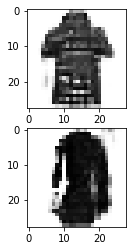

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


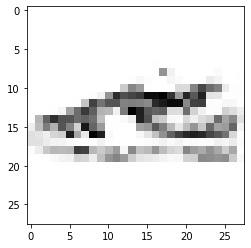

generation 진행 : 0
tensor(12.8600)
tensor([3])
tensor(12.8553)
tensor([3])
tensor(12.8492)
tensor([3])
tensor(12.8441)
tensor([3])
tensor(12.8437)
tensor([3])
tensor(12.8404)
tensor([3])
tensor(12.8363)
tensor([3])
tensor(12.8309)
tensor([3])
tensor(12.8260)
tensor([3])
tensor(12.8245)
tensor([3])
generation 진행 : 10
tensor(12.8201)
tensor([3])
tensor(12.8181)
tensor([3])
tensor(12.8132)
tensor([3])
tensor(12.8108)
tensor([3])
tensor(12.8074)
tensor([3])
tensor(12.8047)
tensor([3])
tensor(12.8006)
tensor([3])
tensor(12.8000)
tensor([3])
tensor(12.7909)
tensor([3])
generation 진행 : 20
tensor(12.7865)
tensor([6])
tensor(12.7810)
tensor([3])
tensor(12.7754)
tensor([6])
tensor(12.7736)
tensor([6])
tensor(12.7711)
tensor([6])
tensor(12.7688)
tensor([3])
tensor(12.7605)
tensor([3])
tensor(12.7563)
tensor([3])
tensor(12.7532)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([5]) 인덱스는 4723


<Figure size 432x288 with 0 Axes>

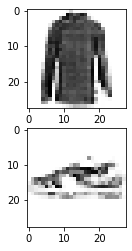

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


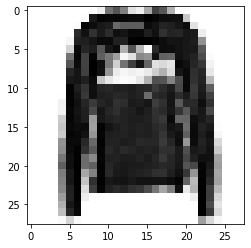

generation 진행 : 0
tensor(11.9012)
tensor([3])
tensor(11.8944)
tensor([3])
tensor(11.8900)
tensor([3])
tensor(11.8885)
tensor([3])
tensor(11.8832)
tensor([3])
tensor(11.8821)
tensor([3])
tensor(11.8788)
tensor([3])
tensor(11.8731)
tensor([3])
tensor(11.8643)
tensor([3])
tensor(11.8604)
tensor([3])
generation 진행 : 10
tensor(11.8549)
tensor([3])
tensor(11.8524)
tensor([3])
tensor(11.8485)
tensor([3])
tensor(11.8473)
tensor([3])
tensor(11.8415)
tensor([3])
tensor(11.8344)
tensor([3])
tensor(11.8301)
tensor([3])
tensor(11.8253)
tensor([3])
tensor(11.8217)
tensor([3])
generation 진행 : 20
tensor(11.8200)
tensor([3])
tensor(11.8158)
tensor([3])
tensor(11.8138)
tensor([3])
tensor(11.8074)
tensor([3])
tensor(11.8044)
tensor([3])
tensor(11.8022)
tensor([3])
tensor(11.7967)
tensor([3])
tensor(11.7916)
tensor([3])
tensor(11.7869)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([4]) 인덱스는 7334


<Figure size 432x288 with 0 Axes>

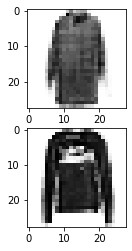

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
 generate


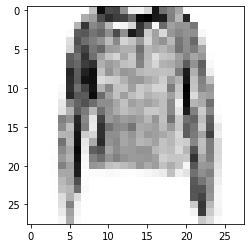

generation 진행 : 0
tensor(12.4980)
tensor([8])
tensor(12.4901)
tensor([8])
tensor(12.4837)
tensor([8])
tensor(12.4801)
tensor([8])
tensor(12.4785)
tensor([8])
tensor(12.4759)
tensor([8])
tensor(12.4737)
tensor([8])
tensor(12.4722)
tensor([8])
tensor(12.4700)
tensor([8])
tensor(12.4661)
tensor([8])
generation 진행 : 10
tensor(12.4599)
tensor([8])
tensor(12.4548)
tensor([8])
tensor(12.4504)
tensor([8])
tensor(12.4443)
tensor([8])
tensor(12.4427)
tensor([8])
tensor(12.4377)
tensor([8])
tensor(12.4330)
tensor([8])
tensor(12.4298)
tensor([8])
tensor(12.4292)
tensor([8])
generation 진행 : 20
tensor(12.4245)
tensor([8])
tensor(12.4201)
tensor([8])
tensor(12.4144)
tensor([8])
tensor(12.4081)
tensor([8])
tensor(12.4019)
tensor([8])
tensor(12.3949)
tensor([8])
tensor(12.3912)
tensor([8])
tensor(12.3886)
tensor([8])
tensor(12.3827)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([4]) 인덱스는 5284


<Figure size 432x288 with 0 Axes>

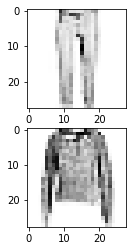

0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 
torch.Size([30, 1, 28, 28])


In [ ]:
##FMNIST용
fin_img_list = []
fin_label_list = []
for i in range(30):
  fin_list, fin_best, best_label = ga(40,30,6000,100,model = LSGAN_FMNIST, NN_model = model_FMNIST, data = None,mutation_prop=0.2) # AE면 32, CAE면 100
  if fin_img_list==[] :
    fin_img_list = LSGAN_FMNIST(fin_best[1].reshape(1,100))
    fin_label_list = best_label
    print(fin_img_list.shape)
  else :
    fin_img_list = torch.cat([fin_img_list,LSGAN_FMNIST(fin_best[1].reshape(1,100)) ])
    fin_label_list = torch.cat([fin_label_list, best_label])
print(fin_img_list.shape)  

In [ ]:
from sklearn.manifold import TSNE
train_MNIST_dataset.targets.shape, train_MNIST_dataset.data.shape
X = ()
Y = ()
for data,idx in train_FMNIST_loader :
  if len(X)>10000:
    break
  if len(X) ==0:
    X = data
    Y = idx
  else :
    X = torch.cat((X,data))
    Y = torch.cat((Y,idx))



#idx = np.random.choice([i for i in range(len(train_MNIST_dataset.targets))],3000)
#Y = train_MNIST_dataset.targets[idx]
#X = train_MNIST_dataset.data[idx]
X = X.reshape([X.size(0),-1])
print(X.shape, Y.shape)

torch.Size([10048, 784]) torch.Size([10048])


torch.Size([10078, 784])


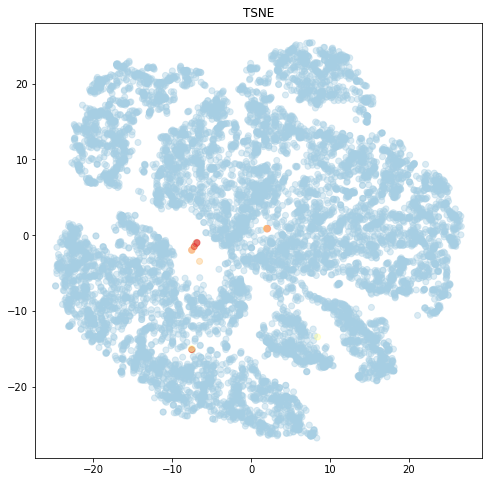

In [ ]:
tsne = TSNE(n_iter=400)
X_check = torch.cat([X,fin_img_list.reshape(-1,784)],dim = 0)
print(X_check.shape)
tsne_results = tsne.fit_transform(X_check.detach().numpy())
Y_check = torch.cat([Y*0, fin_label_list])
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=Y_check, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

10048


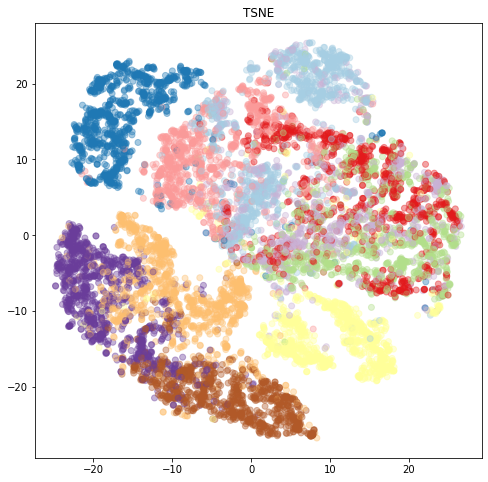

In [ ]:
print(len(X))
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:len(X),0], 
    y=tsne_results[:len(Y),1], 
    c=Y, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

generation 진행 : 0
바뀐 숫자 예측은 tensor([4])
원래 숫자 예측은  tensor([4]) 인덱스는 5817
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

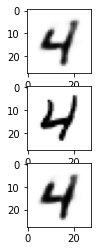

torch.Size([1, 784])
generation 진행 : 0
tensor(1.5365)
tensor([3])
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([3]) 인덱스는 6624
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

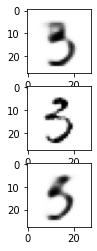

generation 진행 : 0
tensor(0.6345)
tensor([7])
바뀐 숫자 예측은 tensor([7])
원래 숫자 예측은  tensor([9]) 인덱스는 9028
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

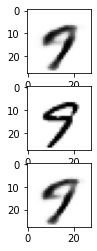

generation 진행 : 0
tensor(0.8968)
tensor([7])
바뀐 숫자 예측은 tensor([7])
원래 숫자 예측은  tensor([5]) 인덱스는 9513
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

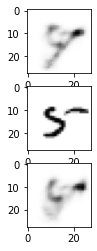

generation 진행 : 0
바뀐 숫자 예측은 tensor([3])
원래 숫자 예측은  tensor([3]) 인덱스는 2392
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

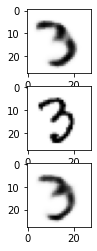

generation 진행 : 0
tensor(1.1439)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([2]) 인덱스는 4274
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

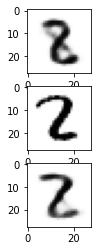

generation 진행 : 0
바뀐 숫자 예측은 tensor([1])
원래 숫자 예측은  tensor([1]) 인덱스는 5524
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

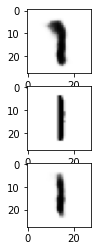

generation 진행 : 0
tensor(0.8669)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([4]) 인덱스는 9103
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

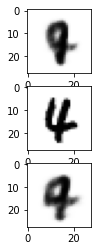

generation 진행 : 0
바뀐 숫자 예측은 tensor([7])
원래 숫자 예측은  tensor([7]) 인덱스는 5310
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

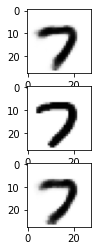

generation 진행 : 0
바뀐 숫자 예측은 tensor([1])
원래 숫자 예측은  tensor([1]) 인덱스는 224
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

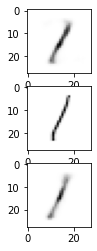

generation 진행 : 0
tensor(0.8737)
tensor([8])
바뀐 숫자 예측은 tensor([8])
원래 숫자 예측은  tensor([2]) 인덱스는 9043
0: T-short/top, 1:Trouser, 2:Pullover, 3:Dress,
4: Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:bag, 9:Ankle boor 


<Figure size 432x288 with 0 Axes>

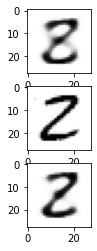

torch.Size([11, 784])


In [ ]:
##MNIST용
fin_img_list = []
fin_label_list = []
for i in range(11):
  fin_list, fin_best, best_label = ga(30,2,6000,10,model = AE_MNIST, NN_model = model_MNIST, data = test_MNIST_dataset,mutation_prop=0.2) # AE면 32, CAE면 100
  if fin_img_list==[] :
    fin_img_list = AE_MNIST.get_decode(fin_best[1]).reshape(1,28*28)
    fin_label_list = best_label
    print(fin_img_list.shape)
  else :
    fin_img_list = torch.cat([fin_img_list,AE_MNIST.get_decode(fin_best[1]).reshape(1,28*28) ])
    fin_label_list = torch.cat([fin_label_list, best_label])
print(fin_img_list.shape)

In [ ]:
from sklearn.manifold import TSNE
train_MNIST_dataset.targets.shape, train_MNIST_dataset.data.shape
X = ()
Y = ()
for data,idx in train_MNIST_loader :
  if len(X)>5000:
    break
  if len(X) ==0:
    X = data
    Y = idx
  else :
    X = torch.cat((X,data))
    Y = torch.cat((Y,idx))



#idx = np.random.choice([i for i in range(len(train_MNIST_dataset.targets))],3000)
#Y = train_MNIST_dataset.targets[idx]
#X = train_MNIST_dataset.data[idx]
X = X.reshape([X.size(0),-1])
print(X.shape, Y.shape)


torch.Size([5056, 784]) torch.Size([5056])


In [ ]:
X_test = ()
Y_test = ()
for data,idx in train_MNIST_loader :
  if len(X_test)>20:
    break
  if len(X_test) ==0:
    X_test = data
    Y_test = idx
  else :
    X_test = torch.cat((X_test,data))
    Y_test = torch.cat((Y_test,idx))
X_ = AE_MNIST(X_test.reshape(-1,1,28,28))[0].reshape(-1,784)
print(X_.shape)
Y_ = Y_test


tsne = TSNE(n_iter=400)
X_check = torch.cat([X,X_],dim = 0)
print(X_check.shape)
tsne_results = tsne.fit_transform(X_check.detach().numpy())

torch.Size([64, 784])
torch.Size([5120, 784])


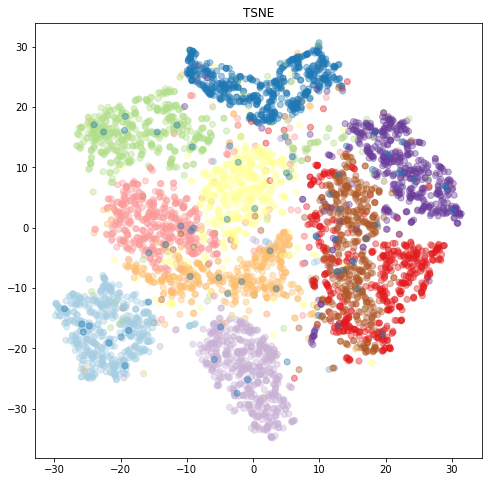

In [ ]:
Y_check = torch.cat([Y, torch.ones_like(Y_)])
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=Y_check, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

torch.Size([5066, 784])


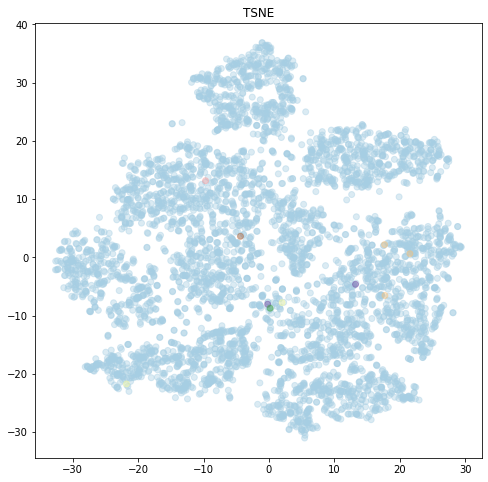

In [ ]:
tsne = TSNE(n_iter=400)
X_check = torch.cat([X,fin_img_list],dim = 0)
print(X_check.shape)
tsne_results = tsne.fit_transform(X_check.detach().numpy())
Y_check = torch.cat([Y*0, fin_label_list])
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=Y_check, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

5056


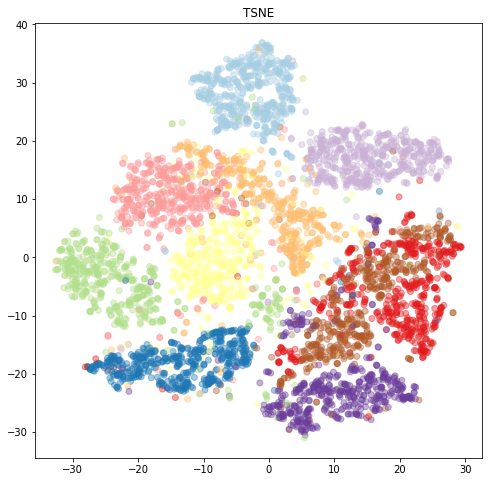

In [ ]:
print(len(X))
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:len(X),0], 
    y=tsne_results[:len(Y),1], 
    c=Y, 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.show()

In [ ]:
np.save('/fin_list.npy', fin)
np.save('/fin_best.npy', best)

In [ ]:
check_list = fin_list#np.load('/content/drive/My Drive/인공지능 정리함/인공지능소공/MNIST_fin_list_4.npy', allow_pickle=True)

In [ ]:
check_list[0][0]

In [ ]:
x,y = test_MNIST_dataset.__getitem__(40)
print(y)
print(torch.max(model_MNIST(AE(x.reshape((1,1,28,28)))[0].cpu().data.reshape(1,1,28,28)), dim=1)[1] )
matplotlib_imshow(AE(x.reshape((1,1,28,28)))[0].cpu().data.reshape(1,28,28), True)

In [ ]:
re_tmp = AE.get_decode(torch.Tensor(check_list[0][1]))
print(re_tmp.shape)
matplotlib_imshow(re_tmp.data.reshape(1,28,28),True)
print(torch.max(model_MNIST(re_tmp.reshape((1,1,28,28))), dim=1)[1] )

In [ ]:
check_list = np.load('/content/drive/My Drive/인공지능 정리함/인공지능소공/fin_list_9.npy', allow_pickle=True)

In [ ]:
x,y = test_FMNIST_dataset.__getitem__(9)
print(y)
matplotlib_imshow(CAE(x.reshape((1,1,28,28))).cpu().data.reshape(1,28,28), True)

In [ ]:
x,y = test_FMNIST_dataset.__getitem__(1088)
print(y)
matplotlib_imshow(CAE(x.reshape((1,1,28,28))).cpu().data.reshape(1,28,28), True)

In [ ]:
re_tmp = CAE.get_decode(torch.Tensor(check_list[0][1]).reshape((1,5,20,20)))
print(re_tmp.shape)
matplotlib_imshow(re_tmp.data.reshape(1,28,28),True)
print(torch.max(model(re_tmp.reshape((1,1,28,28))), dim=1)[1] )

In [ ]:
x,y = test_FMNIST_dataset.__getitem__(6)
print(y)
matplotlib_imshow(CAE(x.reshape((1,1,28,28))).cpu().data.reshape(1,28,28), True)

In [ ]:
x,y = test_FMNIST_dataset.__getitem__(1233)
print(y)
matplotlib_imshow(CAE(x.reshape((1,1,28,28))).cpu().data.reshape(1,28,28), True)

In [ ]:
re_tmp = CAE.get_decode(torch.Tensor(check_list[0][1]).reshape((1,5,20,20)))
print(re_tmp.shape)
matplotlib_imshow(re_tmp.data.reshape(1,28,28),True)
print(torch.max(model(re_tmp.reshape((1,1,28,28))), dim=1)[1] )

In [ ]:
x,y = test_FMNIST_dataset.__getitem__(9)
print(y)
matplotlib_imshow(CAE(x.reshape((1,1,28,28))).cpu().data.reshape(1,28,28), True)

In [ ]:
re_tmp = CAE.get_decode(torch.Tensor(check_list[0][1]).reshape((1,5,20,20)))
print(re_tmp.shape)
matplotlib_imshow(re_tmp.data.reshape(1,28,28),True)
print(torch.max(model(re_tmp.reshape((1,1,28,28))), dim=1)[1] )

In [ ]:
x,y = test_FMNIST_dataset.__getitem__(4)
print(y)
matplotlib_imshow(CAE(x.reshape((1,1,28,28))).cpu().data.reshape(1,28,28), True)